# Import Libraries

In [9]:
# # College Football Score Prediction Model
# This notebook implements machine learning models to predict home points, away points, and spread in college football games.

### 1. Import Dependencies

# Utilities - Import logging first
import logging
import warnings
from datetime import datetime, timedelta
import joblib

# Data manipulation and analysis
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Union
import asyncio
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.base import clone
from dotenv import load_dotenv
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Machine Learning - Core
from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    GridSearchCV,
    TimeSeriesSplit
)

# Preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    RobustScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    make_scorer
)

# Models
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor
)
from sklearn.linear_model import (
    Ridge,
    ElasticNet,
    Lasso
)

import sys
import subprocess
import pkg_resources

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    sklearn_version = pkg_resources.get_distribution('scikit-learn').version
    if sklearn_version.startswith('1.6'):
        print("Downgrading scikit-learn to version 1.5.2...")
        install_package('scikit-learn==1.5.2')
        print("Please restart your kernel to use the new scikit-learn version")
except:
    print("Installing scikit-learn version 1.5.2...")
    install_package('scikit-learn==1.5.2')
    print("Please restart your kernel to use the new scikit-learn version")
try:
    from xgboost import XGBRegressor
    logger = logging.getLogger("cfb")
    XGBOOST_AVAILABLE = True
except ImportError:
    logger.warning("XGBoost not installed. XGBoost models will not be available.")
    XGBOOST_AVAILABLE = False

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Type aliases for clarity
ArrayLike = Union[np.ndarray, pd.Series, List]
DataFrameLike = Union[pd.DataFrame, pd.Series]

# Suppress warnings
warnings.filterwarnings('ignore')

# API Setup

In [10]:
import os, asyncio, math, traceback
from pathlib import Path
from dotenv import load_dotenv
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from aiohttp import ClientTimeout

# 1) Load your key
load_dotenv(Path.cwd() / ".env")
CFB_API_KEY = os.getenv("CFB_API_KEY")
if not CFB_API_KEY:
    raise RuntimeError("Missing CFB_API_KEY in environment/.env")

# 2) Transport with generous HTTP timeouts
transport = AIOHTTPTransport(
    url="https://graphql.collegefootballdata.com/v1/graphql",
    headers={"Authorization": f"Bearer {CFB_API_KEY}"},
    # aiohttp timeouts (connect+read)
    client_session_args={"timeout": ClientTimeout(total=120, connect=20, sock_read=120)},
    timeout=120,  # gql transport timeout (seconds)
)

# 3) Client execute timeout (wraps the whole request)
client = Client(transport=transport, fetch_schema_from_transport=False, execute_timeout=180)

# Tiny probe so auth/transport errors are obvious
async def _probe():
    try:
        await client.execute_async(gql("query { __typename }"))
    except Exception as e:
        raise RuntimeError(f"Probe failed ({type(e).__name__}): {e!r}")


# Import Data

In [11]:
import asyncio
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

# You'll need to configure your client with fetch_schema_from_transport=False
# Add this before your query definition (replace with your actual endpoint URL):
# transport = AIOHTTPTransport(url="YOUR_GRAPHQL_ENDPOINT_URL")
# client = Client(transport=transport, fetch_schema_from_transport=False)

query = gql("""
query gamesQuery($startYear: smallint!, $endYear: smallint!, $offset: Int!) {
  adjustedTeamMetrics {
    teamId
    epa
    epaAllowed
    explosiveness
    explosivenessAllowed
    lineYards
    lineYardsAllowed
    openFieldYards
    openFieldYardsAllowed
    passingDownsSuccess
    passingDownsSuccessAllowed
    passingEpa
    passingEpaAllowed
    rushingEpa
    rushingEpaAllowed
    secondLevelYards
    secondLevelYardsAllowed
    standardDownsSuccess
    standardDownsSuccessAllowed
    success
    successAllowed
    team {
      school
      conference
      classification
    }
    year
  }
  gameLines {
    gameId
    moneylineAway
    moneylineHome
    overUnder
    overUnderOpen
    spread
    spreadOpen
  }
  gameWeather {
    gameId
    temperature
    humidity
    windSpeed
    precipitation
    pressure
    snowfall
    weatherConditionCode
    windDirection
    windGust
  }
  teamTalent {
    talent
    team {
      teamId
      school
      conference
    }
    year
  }
  currentTeams {
    teamId
    school
    conference
    classification
    division
  }
  ratings(    where: {_and: [{year: {_gte: $startYear}}, {year: {_lte: $endYear}}]}
) {
    conference
    conferenceId
    elo
    fpi
    fpiAvgWinProbabilityRank
    fpiDefensiveEfficiency
    fpiGameControlRank
    fpiOffensiveEfficiency
    fpiOverallEfficiency
    fpiRemainingSosRank
    fpiResumeRank
    fpiSosRank
    fpiSpecialTeamsEfficiency
    fpiStrengthOfRecordRank
    spDefense
    spOffense
    spOverall
    spSpecialTeams
    srs
    team
    teamId
    year
  }
  teamTalent {
    talent
    year
    team {
      teamId
      school
      conference
    }
  }
  game(
    where: {_and: [{season: {_gte: $startYear}}, {season: {_lte: $endYear}}]}
    offset: $offset
    limit: 1000
    orderBy: [{season: ASC}]
  ) {
    id
    season
    week
    homeTeam
    homePoints
    homeTeamId
    homeTeamInfo {
      school
      conference
    }
    awayTeam
    awayPoints
    awayTeamId
    awayTeamInfo {
      school
      conference
    }
    startDate
    neutralSite
    seasonType
    attendance
    excitement
    homeStartElo
    homeEndElo
    awayStartElo
    awayEndElo
    homePostgameWinProb
    awayPostgameWinProb
    homeLineScores
    awayLineScores
    conferenceGame
  }
}
""")

async def fetch_all_games():
    all_games = []
    all_data = {}
    offset = 0
    first_batch = True
    validation_info = {}

    while True:
        variables = {
            "startYear": 2018,
            "endYear": 2025, 
            "offset": offset
        }
        
        try:
            result = await client.execute_async(query, variable_values=variables)
            
            if first_batch:
                all_data = {
                    'gameLines': result.get('gameLines', []),
                    'gameWeather': result.get('gameWeather', []),
                    'adjustedTeamMetrics': result.get('adjustedTeamMetrics', []),
                    'teamTalent': result.get('teamTalent', []),
                    'currentTeams': result.get('currentTeams', []),
                    'ratings': result.get('ratings', []), 
                    'predictedPoints': result.get('predictedPoints', []) 
                }
                first_batch = False

            games_batch = result.get('game', [])
            
            if not games_batch:  
                break
                
            all_games.extend(games_batch)
            print(f"Fetched {len(games_batch)} games (years: {min(g['season'] for g in games_batch)}-{max(g['season'] for g in games_batch)}), total so far: {len(all_games)}")
            
            if len(games_batch) < 1000: 
                break
                
            offset += 1000
            
        except Exception as e:
            print(f"Error fetching games at offset {offset}: {str(e)}")
            if not all_games:  # If we haven't successfully fetched any games
                raise  # Re-raise the exception
            break  # Otherwise break and return what we have

    # Combine all data
    all_data['game'] = all_games

    # Data validation 
    print("\nRaw API Response:")
    validation_info['metrics_years'] = sorted(set(m['year'] for m in all_data['adjustedTeamMetrics']))
    validation_info['games_years'] = sorted(set(g['season'] for g in all_data['game']))
    validation_info['talent_years'] = sorted(set(t['year'] for t in all_data['teamTalent']))
    print("\nMetrics years available:", validation_info['metrics_years'])
    print("\nGames years available:", validation_info['games_years']) 
    print("\nTeam Talent years available:", validation_info['talent_years'])

    print("\nTotal counts in raw data:")
    print(f"Metrics records: {len(all_data['adjustedTeamMetrics'])}")
    print(f"Games records: {len(all_data['game'])}")
    print(f"Team Talent records: {len(all_data['teamTalent'])}")
    print(f"Game Lines records: {len(all_data['gameLines'])}")
    print(f"Game Weather records: {len(all_data['gameWeather'])}")

    # Season distribution
    season_counts = {}
    for game in all_data['game']:
        season = game['season']
        season_counts[season] = season_counts.get(season, 0) + 1
    validation_info['season_counts'] = dict(sorted(season_counts.items()))
    print("\nUnique season values in games:")
    print("Season distribution:", validation_info['season_counts'])

    # Data completeness checks
    games_with_both_scores = sum(1 for g in all_data['game'] if g['homePoints'] is not None and g['awayPoints'] is not None)
    print("\nData completeness checks:")
    print(f"Games with both scores: {games_with_both_scores} ({games_with_both_scores/len(all_data['game'])*100:.1f}%)")

    games_with_weather = sum(1 for g in all_data['gameWeather'])
    print(f"Games with weather data: {games_with_weather} ({games_with_weather/len(all_data['game'])*100:.1f}%)")

    games_with_lines = sum(1 for g in all_data['gameLines'])
    print(f"Games with betting lines: {games_with_lines} ({games_with_lines/len(all_data['game'])*100:.1f}%)")

    # API error check
    print("\nAPI limits:")
    if 'errors' in result:
        print("API Errors:", result['errors'])
    else:
        print("No API errors found")

    # Missing value checks
    print("\nMissing values in key fields:")
    missing_home_points = sum(1 for g in all_data['game'] if g['homePoints'] is None)
    missing_away_points = sum(1 for g in all_data['game'] if g['awayPoints'] is None)
    missing_start_date = sum(1 for g in all_data['game'] if g['startDate'] is None)

    print(f"Missing home points: {missing_home_points}")
    print(f"Missing away points: {missing_away_points}")
    print(f"Missing start dates: {missing_start_date}")

    # Store validation info
    all_data['validation'] = validation_info

    return all_data

# Execute with proper error handling
try:
    result = await fetch_all_games()  
    print("\nData fetch completed successfully!")
except Exception as e:
    print(f"Fatal error during data fetch: {str(e)}")
    raise

Fetched 1000 games (years: 2018-2018), total so far: 1000
Fetched 1000 games (years: 2018-2019), total so far: 2000
Fetched 1000 games (years: 2019-2019), total so far: 3000
Fetched 1000 games (years: 2019-2020), total so far: 4000
Fetched 1000 games (years: 2020-2021), total so far: 5000
Fetched 1000 games (years: 2021-2021), total so far: 6000
Fetched 1000 games (years: 2021-2022), total so far: 7000
Fetched 1000 games (years: 2022-2022), total so far: 8000
Fetched 1000 games (years: 2022-2022), total so far: 9000
Fetched 1000 games (years: 2022-2022), total so far: 10000
Fetched 1000 games (years: 2022-2023), total so far: 11000
Fetched 1000 games (years: 2023-2023), total so far: 12000
Fetched 1000 games (years: 2023-2023), total so far: 13000
Fetched 1000 games (years: 2023-2023), total so far: 14000
Fetched 1000 games (years: 2023-2024), total so far: 15000
Fetched 1000 games (years: 2024-2024), total so far: 16000
Fetched 1000 games (years: 2024-2024), total so far: 17000
Fetche

# Data Refinement

Creating DataFrames from API result...

Merging data sources...

Completeness Summary:
    column  completeness_%  missing_count
homePoints           88.83           1890
awayPoints           88.83           1890
    spread           38.85          10351
 overUnder           38.21          10459
       elo           35.01          11000
       fpi           34.85          11027
 spOverall           34.85          11027
       srs           30.68          11733

Season Breakdown:
Season | Games | Lines | Weather | ELO | FPI
------------------------------------------------------------
  2018 |  1556 |   862 |     871 |  896 |  884
  2019 |  1623 |   881 |     875 |  903 |  888
  2020 |  1125 |   566 |     560 |  568 |  568
  2021 |  2454 |   887 |     853 |  887 |  887
  2022 |  2785 |  1063 |    2396 |  735 |  735
  2023 |  2506 |   827 |    2116 |  632 |  632
  2024 |  2623 |  1235 |    2289 |  785 |  785
  2025 |   364 |   254 |     467 |  520 |  520

Data Overview:
------------------

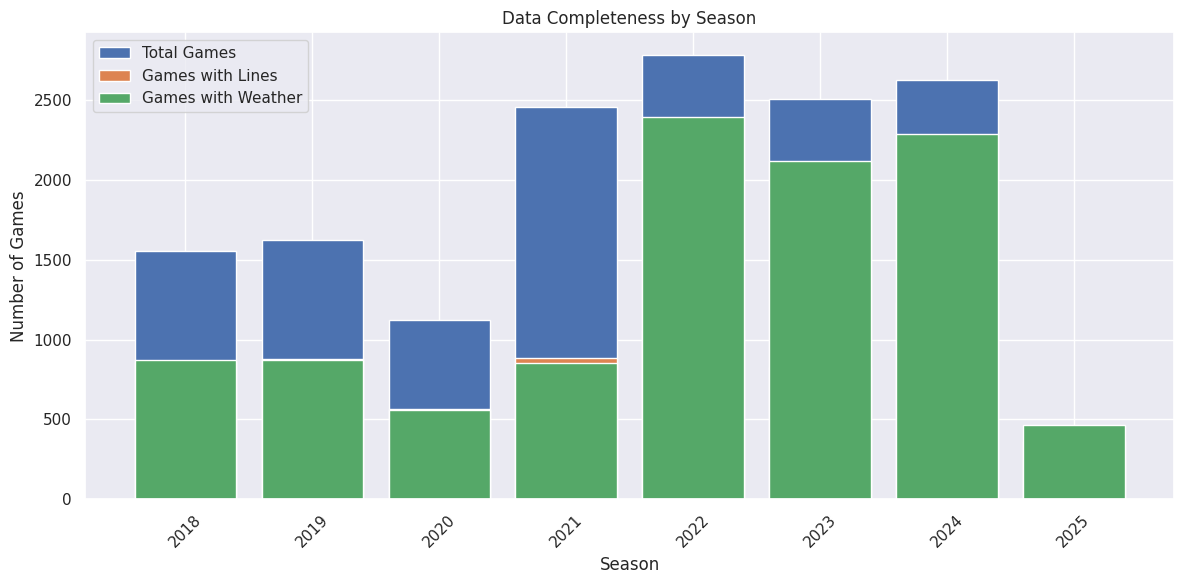


Problematic Rows (preview):
 season  week           homeTeam           awayTeam  homePoints  awayPoints  elo  fpi
   2018     1 Eastern Washington Central Washington        58.0        13.0  NaN  NaN
   2018     1 Jacksonville State North Carolina A&T        17.0        20.0  NaN  NaN
   2018     1             Wagner        Bowie State        40.0        23.0  NaN  NaN
   2018     1      Indiana State             Quincy        49.0         0.0  NaN  NaN
   2018     1           Campbell             Chowan        49.0        26.0  NaN  NaN
   2018     1           Delaware       Rhode Island        19.0        21.0  NaN  NaN
   2018     1              Maine      New Hampshire        35.0         7.0  NaN  NaN
   2018     1        Chattanooga     Tennessee Tech        34.0        10.0  NaN  NaN
   2018     1   Eastern Kentucky     Morehead State        49.0        23.0  NaN  NaN
   2018     1       Murray State  Southern Illinois        10.0        49.0  NaN  NaN


In [15]:
# %% [markdown]
# ## Build games_df with ratings normalization + presence flags + season breakdown (single working cell)

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- column sets ----------
team_info_cols = [
    'teamId', 'year', 'school', 'conference', 'classification',
    'division', 'talent', 'conferenceId'
]

game_info_cols = [
    'id',
    'homeTeam', 'awayTeam', 'homeTeamId', 'awayTeamId',
    'homePoints', 'awayPoints', 'week', 'season', 'seasonType',
    'startDate', 'neutralSite', 'attendance', 'excitement',
    'homeConference', 'awayConference',
    'homeStartElo', 'homeEndElo', 'awayStartElo', 'awayEndElo',
    'homePostgameWinProb', 'awayPostgameWinProb',
    'homeLineScores', 'awayLineScores',
    'conferenceGame'
]

offense_cols = [
    'epa', 'explosiveness',
    'passingEpa', 'rushingEpa',
    'success', 'passingDownsSuccess', 'standardDownsSuccess',
    'lineYards', 'openFieldYards', 'secondLevelYards'
]

defense_cols = [
    'epaAllowed', 'explosivenessAllowed',
    'passingEpaAllowed', 'rushingEpaAllowed',
    'successAllowed', 'passingDownsSuccessAllowed', 'standardDownsSuccessAllowed',
    'lineYardsAllowed', 'openFieldYardsAllowed', 'secondLevelYardsAllowed'
]

betting_cols = [
    'spread', 'spreadOpen',
    'overUnder', 'overUnderOpen',
    'moneylineHome', 'moneylineAway'
]

weather_cols = [
    'temperature', 'humidity', 'windSpeed', 'windDirection',
    'precipitation', 'pressure', 'snowfall',
    'weatherConditionCode', 'windGust'
]

ratings_cols = [
    'elo', 'fpi', 'fpiAvgWinProbabilityRank', 'fpiDefensiveEfficiency',
    'fpiGameControlRank', 'fpiOffensiveEfficiency', 'fpiOverallEfficiency',
    'fpiRemainingSosRank', 'fpiResumeRank', 'fpiSosRank',
    'fpiSpecialTeamsEfficiency', 'fpiStrengthOfRecordRank',
    'spDefense', 'spOffense', 'spOverall', 'spSpecialTeams', 'srs'
]

predicted_points_cols = ['distance', 'down', 'predictedPoints']

matchup_stats_cols = [
    'conferenceGame',
    'homeStartElo', 'awayStartElo',
    'homeEndElo', 'awayEndElo',
    'homePostgameWinProb', 'awayPostgameWinProb'
]

# ---------- helpers ----------
def _fill_rating_block(df, base):
    """Forward-fill per team, then fill by conference mean, then global mean for home_* and away_* bases."""
    for side in ['home', 'away']:
        col = f'{side}_{base}'
        if col in df.columns:
            team_id = f'{side}TeamId'
            conf_col = f'{side}_conference'
            # per team ffill
            if team_id in df.columns:
                df[col] = df.groupby(team_id)[col].transform(lambda x: x.ffill())
            # per conf mean
            if conf_col in df.columns:
                df[col] = df.groupby(conf_col)[col].transform(lambda x: x.fillna(x.mean()))
            # global mean
            df[col] = df[col].fillna(df[col].mean())

def handle_missing_data(df):
    df = df.copy()

    # Scores
    for col in ['homePoints', 'awayPoints']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # Conferences
    for col in ['home_conference', 'away_conference']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    # Team metrics (epa/success/etc.)
    team_metric_cols = [c for c in df.columns if any(x in c for x in ['epa', 'success', 'explosiveness'])]
    for col in team_metric_cols:
        if 'home_conference' in df.columns:
            df[col] = df.groupby('home_conference')[col].transform(lambda x: x.fillna(x.mean()))
        df[col] = df[col].fillna(df[col].mean())

    # Weather
    for col in ['temperature', 'humidity', 'windSpeed']:
        if col in df.columns:
            if set(['season', 'week']).issubset(df.columns):
                df[col] = df.groupby(['season', 'week'])[col].transform(lambda x: x.fillna(x.mean()))
            df[col] = df[col].fillna(df[col].mean())

    # Ratings — handle both home_* and away_* forms
    for base in ['elo', 'fpi', 'spOverall', 'srs']:
        _fill_rating_block(df, base)

    # Context
    for col in ['rest_days', 'attendance']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Ensure required cols exist
    for col in ['epa', 'success', 'explosiveness', 'home_epa', 'away_epa',
                'home_epaAllowed', 'away_epaAllowed', 'home_fpi', 'away_fpi', 'home_spOverall', 'away_spOverall']:
        if col not in df.columns:
            df[col] = 0

    return df

def normalize_rating_columns(gdf: pd.DataFrame) -> pd.DataFrame:
    """Map unsuffixed/*_home/*_away rating columns to home_* / away_* consistently. Also normalize StartElo."""
    gdf = gdf.copy()
    RATINGS = [
        'elo', 'fpi', 'fpiAvgWinProbabilityRank', 'fpiDefensiveEfficiency',
        'fpiGameControlRank', 'fpiOffensiveEfficiency', 'fpiOverallEfficiency',
        'fpiRemainingSosRank', 'fpiResumeRank', 'fpiSosRank',
        'fpiSpecialTeamsEfficiency', 'fpiStrengthOfRecordRank',
        'spDefense', 'spOffense', 'spOverall', 'spSpecialTeams', 'srs'
    ]
    ren = {}
    # Home side: unsuffixed or *_home -> home_*
    for col in RATINGS:
        if col in gdf.columns:
            ren[col] = f'home_{col}'
        if f'{col}_home' in gdf.columns:
            ren[f'{col}_home'] = f'home_{col}'
    # Away side: *_away -> away_*
    for col in RATINGS:
        if f'{col}_away' in gdf.columns:
            ren[f'{col}_away'] = f'away_{col}'
    # Normalize Elo Start
    if 'homeStartElo' in gdf.columns:
        ren['homeStartElo'] = 'home_StartElo'
    if 'awayStartElo' in gdf.columns:
        ren['awayStartElo'] = 'away_StartElo'
    return gdf.rename(columns=ren)

def make_side_mean(df: pd.DataFrame, base: str, out: str) -> pd.DataFrame:
    """Row-wise mean of home_* and away_* for a rating base name."""
    h, a = f'home_{base}', f'away_{base}'
    if h in df.columns or a in df.columns:
        df[out] = np.nanmean(
            np.vstack([
                pd.to_numeric(df.get(h, np.nan), errors='coerce'),
                pd.to_numeric(df.get(a, np.nan), errors='coerce')
            ]),
            axis=0
        )
    return df

def add_legacy_rating_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create legacy unsuffixed columns ('elo','fpi','spOverall','srs') so code that expects them won't break.
    Prefer *_mean if available; otherwise average home_/away_.
    """
    df = df.copy()
    bases = ['elo', 'fpi', 'spOverall', 'srs']
    for base in bases:
        if base not in df.columns:
            mean_col = f'{base}_mean'
            h, a = f'home_{base}', f'away_{base}'
            if mean_col in df.columns:
                df[base] = pd.to_numeric(df[mean_col], errors='coerce')
            elif (h in df.columns) or (a in df.columns):
                df[base] = (
                    pd.to_numeric(df.get(h), errors='coerce') +
                    pd.to_numeric(df.get(a), errors='coerce')
                ) / 2.0
            else:
                df[base] = np.nan
    return df

def ensure_presence_flags(df: pd.DataFrame) -> pd.DataFrame:
    """Create elo_present / fpi_present flags using home_* and away_* (fallback to StartElo for elo)."""
    df = df.copy()

    def present(left, right):
        l = pd.to_numeric(df.get(left), errors='coerce').notna() if left in df.columns else False
        r = pd.to_numeric(df.get(right), errors='coerce').notna() if right in df.columns else False
        return (l | r).astype(int)

    # elo: prefer home_elo/away_elo; fallback to StartElo if both missing
    df['elo_present'] = present('home_elo', 'away_elo')
    if df['elo_present'].sum() == 0:
        df['elo_present'] = present('home_StartElo', 'away_StartElo')

    df['fpi_present'] = present('home_fpi', 'away_fpi')
    return df

# ---------- build DataFrames from `result` ----------
if 'result' not in globals():
    raise RuntimeError("`result` (API response) is not defined in this notebook scope.")

print("Creating DataFrames from API result...")
metrics_df = pd.DataFrame(result.get('adjustedTeamMetrics', []))
teams_df   = pd.DataFrame(result.get('currentTeams', []))
games_df   = pd.DataFrame(result.get('game', []))
lines_df   = pd.DataFrame(result.get('gameLines', []))
weather_df = pd.DataFrame(result.get('gameWeather', []))
talent_df  = pd.DataFrame(result.get('teamTalent', []))
ratings_df = pd.DataFrame(result.get('ratings', [])) if 'ratings' in result else pd.DataFrame()
predicted_points_df = pd.DataFrame(result.get('predictedPoints', [])) if 'predictedPoints' in result else pd.DataFrame()

# Clean numeric lines
for col in ['spread','spreadOpen','overUnder','overUnderOpen','moneylineHome','moneylineAway']:
    if col in lines_df.columns:
        lines_df[col] = pd.to_numeric(lines_df[col], errors='coerce')

# explode nested team info (metrics)
if 'team' in metrics_df.columns:
    team_info = pd.json_normalize(metrics_df['team'].dropna())
    metrics_df = metrics_df.drop(columns=['team'])
    for c in team_info.columns:
        metrics_df[f'team_{c}'] = team_info[c]

# explode nested team info (games)
if 'homeTeamInfo' in games_df.columns:
    home_info = pd.json_normalize(games_df['homeTeamInfo'].dropna())
    games_df = games_df.drop(columns=['homeTeamInfo'])
    for c in home_info.columns:
        games_df[f'home_{c}'] = home_info[c].fillna('Unknown')

if 'awayTeamInfo' in games_df.columns:
    away_info = pd.json_normalize(games_df['awayTeamInfo'].dropna())
    games_df = games_df.drop(columns=['awayTeamInfo'])
    for c in away_info.columns:
        games_df[f'away_{c}'] = away_info[c].fillna('Unknown')

# explode nested team info (talent)
if 'team' in talent_df.columns:
    tinfo = pd.json_normalize(talent_df['team'].dropna())
    talent_df = talent_df.drop(columns=['team'])
    for c in tinfo.columns:
        talent_df[f'team_{c}'] = tinfo[c]

# ---------- merges ----------
print("\nMerging data sources...")
games_df = pd.merge(games_df, lines_df,   left_on='id', right_on='gameId', how='left')
games_df = pd.merge(games_df, weather_df, left_on='id', right_on='gameId', how='left')

# ratings twice (home/away)
if not ratings_df.empty:
    games_df = pd.merge(
        games_df, ratings_df, left_on=['homeTeamId','season'], right_on=['teamId','year'],
        how='left', suffixes=('', '_home')
    )
    games_df = pd.merge(
        games_df, ratings_df, left_on=['awayTeamId','season'], right_on=['teamId','year'],
        how='left', suffixes=('', '_away')
    )

# Convert key numerics (only those present)
numeric_game_cols = [
    'homePoints', 'awayPoints', 'homeStartElo', 'homeEndElo',
    'awayStartElo', 'awayEndElo', 'homePostgameWinProb', 'awayPostgameWinProb',
    'temperature', 'humidity', 'windSpeed'
] + [c for c in ratings_cols if c in games_df.columns]

for col in set(numeric_game_cols):
    if col in games_df.columns:
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')

# ---------- rating normalization & flags ----------
games_df = normalize_rating_columns(games_df)

# also compute *_mean helpers so we can create legacy columns later
for base in ['elo','fpi','spOverall','srs']:
    games_df = make_side_mean(games_df, base, f'{base}_mean')

# add legacy unsuffixed columns and presence flags
games_df = add_legacy_rating_columns(games_df)
games_df = ensure_presence_flags(games_df)

# numeric coercion for normalized & legacy cols
for col in [
    'home_StartElo','away_StartElo',
    'home_elo','away_elo','home_fpi','away_fpi',
    'home_spOverall','away_spOverall','home_srs','away_srs',
    'elo','fpi','spOverall','srs'
]:
    if col in games_df.columns:
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')

# ---------- light missing-data handling where useful ----------
if 'startDate' in games_df.columns:
    games_df['startDate'] = pd.to_datetime(games_df['startDate'], errors='coerce')

# ensure conference string cols exist for prints
if 'home_conference' not in games_df.columns and 'home_conference' in games_df.filter(like='home_').columns:
    pass  # already covered by normalized fields added above if any
# (if still missing, prints will skip)

# de-duplicate obvious repeats
if set(['homeTeamId','homeTeam','awayTeam','week','season']).issubset(games_df.columns):
    games_df = games_df.drop_duplicates(
        subset=['homeTeamId','homeTeam','awayTeam','week','season'],
        keep='first'
    )

# ---------- completeness summary ----------
important_cols = [
    'homePoints','awayPoints','spread','overUnder',
    'elo','fpi','spOverall','srs'
]
print("\nCompleteness Summary:")
rows = []
for col in important_cols:
    if col in games_df.columns:
        valid = pd.to_numeric(games_df[col], errors='coerce').notna()
        rows.append({
            'column': col,
            'completeness_%': round(valid.mean()*100, 2),
            'missing_count': int((~valid).sum())
        })
if rows:
    print(pd.DataFrame(rows).to_string(index=False))
else:
    print("No tracked columns present to summarize.")

# ---------- season breakdown ----------
agg = {
    'homePoints': 'count',
    'spread':      lambda x: pd.to_numeric(x, errors='coerce').notna().sum(),
    'temperature': lambda x: pd.to_numeric(x, errors='coerce').notna().sum(),
}
# include presence flags if present
for c in ['elo_present','fpi_present']:
    if c in games_df.columns:
        agg[c] = 'sum'

if 'season' in games_df.columns:
    games_by_season = (
        games_df.groupby('season')
        .agg(agg)
        .fillna(0)
        .astype(int)
        .sort_index()
    )

    print("\nSeason Breakdown:")
    print("Season | Games | Lines | Weather | ELO | FPI")
    print("-" * 60)
    for season, row in games_by_season.iterrows():
        elo_sum = row.get('elo_present', 0)
        fpi_sum = row.get('fpi_present', 0)
        print(f"{int(season):6d} | {row['homePoints']:5d} | {row['spread']:5d} | "
              f"{row['temperature']:7d} | {elo_sum:4d} | {fpi_sum:4d}")
else:
    print("\nNo 'season' column — skipping season breakdown.")

# ---------- quick overview ----------
print("\nData Overview:")
print("-"*50)
print(f"Total unique games: {len(games_df)}")
if 'season' in games_df.columns:
    try:
        print(f"Years in data: {sorted(pd.Series(games_df['season'].dropna().unique(), dtype=int))}")
    except Exception:
        print(f"Years in data: {sorted(games_df['season'].dropna().unique())}")
if 'homeTeamId' in games_df.columns:
    print(f"Teams: {games_df['homeTeamId'].nunique()}")

# games per year
if 'season' in games_df.columns:
    print("\nGames per year:")
    print(games_df.groupby('season').size())

# data completeness chart (no seaborn)
if 'season' in locals() and 'games_by_season' in locals():
    season_stats = games_by_season[['homePoints','spread','temperature']]
    plt.figure(figsize=(12, 6))
    plt.bar(season_stats.index, season_stats['homePoints'], label='Total Games')
    plt.bar(season_stats.index, season_stats['spread'], label='Games with Lines')
    plt.bar(season_stats.index, season_stats['temperature'], label='Games with Weather')
    plt.title('Data Completeness by Season')
    plt.xlabel('Season')
    plt.ylabel('Number of Games')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ---------- problematic rows preview (won’t KeyError if elo/fpi missing) ----------
elo_series = pd.to_numeric(
    games_df.get('elo',
        (pd.to_numeric(games_df.get('home_elo'), errors='coerce') +
         pd.to_numeric(games_df.get('away_elo'), errors='coerce')) / 2.0
    ),
    errors='coerce'
)
fpi_series = pd.to_numeric(
    games_df.get('fpi',
        (pd.to_numeric(games_df.get('home_fpi'), errors='coerce') +
         pd.to_numeric(games_df.get('away_fpi'), errors='coerce')) / 2.0
    ),
    errors='coerce'
)

problem_mask = (
    pd.to_numeric(games_df.get('homePoints'), errors='coerce').isna() |
    pd.to_numeric(games_df.get('awayPoints'), errors='coerce').isna() |
    (elo_series.isna() & fpi_series.isna())
)

if problem_mask.any():
    cols_preview = [c for c in ['season','week','homeTeam','awayTeam','homePoints','awayPoints','elo','fpi'] if c in games_df.columns]
    print("\nProblematic Rows (preview):")
    print(games_df.loc[problem_mask, cols_preview].head(10).to_string(index=False))
else:
    print("\nNo problematic rows found.")


# Data Visualization


Sample game with detailed metrics:
   season  week            homeTeam            awayTeam  homePoints  awayPoints  spread  overUnder  temperature  elo  fpi  spOverall  srs
0    2018     1  Eastern Washington  Central Washington        58.0        13.0     NaN        NaN          NaN  NaN  NaN        NaN  NaN

Detailed Game Stats:
Home Points - Mean: 29.6, Std: 15.7
Away Points - Mean: 24.4, Std: 14.5
Total Points - Mean: 54.1, Std: 18.0
Home Win %: 51.6%

Rating Stats:
elo - Mean: 1507.1, Std: 220.1
fpi - Mean: 0.4, Std: 10.0
spOverall - Mean: 1.2, Std: 10.7
srs - Mean: 0.4, Std: 9.7

Efficiency Stats:

Betting Line Stats:
Spread - Mean: -6.5, Std: 15.9
Over/Under - Mean: 54.5, Std: 7.8


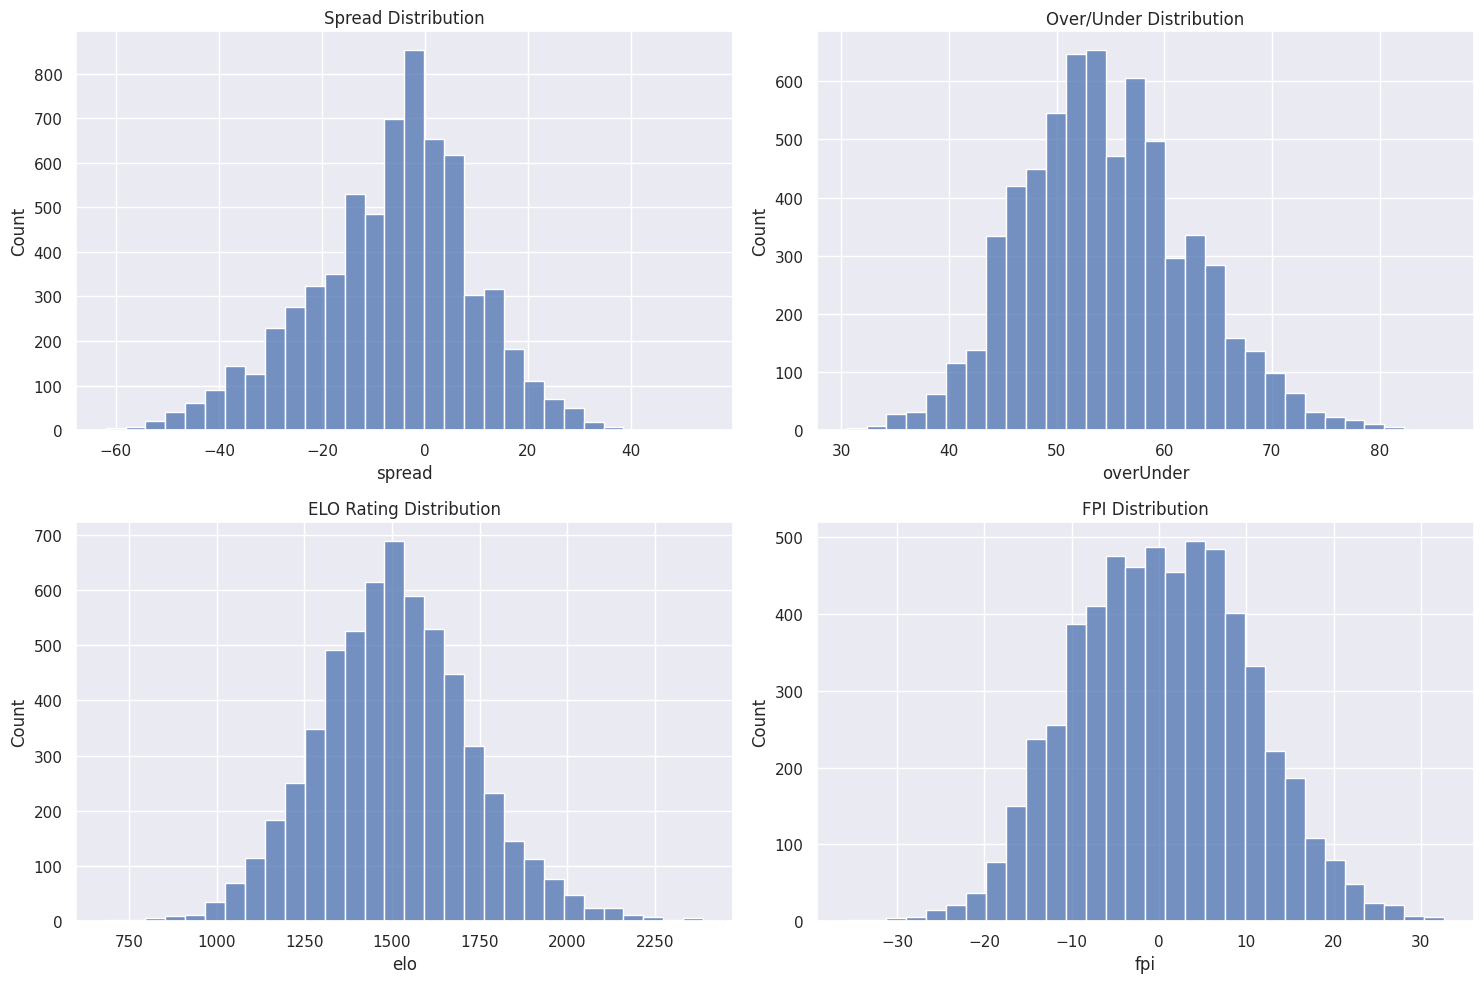


Detailed Data Completeness:

Completeness Summary:
    column  completeness  missing_count
homePoints     88.833747           1890
awayPoints     88.833747           1890
    spread     38.845563          10351
 overUnder     38.207491          10459
       elo     35.011225          11000
       fpi     34.851707          11027
 spOverall     34.851707          11027
       srs     30.680610          11733

Data Source Validation:

Season Breakdown:
Season | Games | Lines | Weather | ELO | FPI
------------------------------------------------------------
  2018 |  1556 |   862 |     871 |  896 |  884
  2019 |  1623 |   881 |     875 |  903 |  888
  2020 |  1125 |   566 |     560 |  568 |  568
  2021 |  2454 |   887 |     853 |  887 |  887
  2022 |  2785 |  1063 |    2396 |  735 |  735
  2023 |  2506 |   827 |    2116 |  632 |  632
  2024 |  2623 |  1235 |    2289 |  785 |  785
  2025 |   364 |   254 |     467 |  520 |  520

Detailed Column Information:
<class 'pandas.core.frame.DataFr

In [16]:
# Split home and away metrics for better analysis
print("\nSample game with detailed metrics:")
metric_cols = ['season', 'week', 'homeTeam', 'awayTeam', 'homePoints', 'awayPoints',
              'spread', 'overUnder', 'temperature',
              'epa', 'epaAllowed', 'success', 'successAllowed',
              'elo', 'fpi', 'spOverall', 'srs',  # Added rating metrics
              'fpiOffensiveEfficiency', 'fpiDefensiveEfficiency', 'fpiSpecialTeamsEfficiency']
existing_cols = [col for col in metric_cols if col in games_df.columns]
game_view = games_df[existing_cols].head(1)
print(game_view.to_string())

# Enhanced basic stats
print("\nDetailed Game Stats:")
home_points = pd.to_numeric(games_df['homePoints'], errors='coerce')
away_points = pd.to_numeric(games_df['awayPoints'], errors='coerce')
total_points = home_points + away_points

print(f"Home Points - Mean: {home_points.mean():.1f}, Std: {home_points.std():.1f}")
print(f"Away Points - Mean: {away_points.mean():.1f}, Std: {away_points.std():.1f}")
print(f"Total Points - Mean: {total_points.mean():.1f}, Std: {total_points.std():.1f}")
print(f"Home Win %: {(home_points > away_points).mean()*100:.1f}%")

# Add Rating Stats
print("\nRating Stats:")
rating_cols = ['elo', 'fpi', 'spOverall', 'srs']
for col in rating_cols:
    if col in games_df.columns:
        values = pd.to_numeric(games_df[col], errors='coerce')
        print(f"{col} - Mean: {values.mean():.1f}, Std: {values.std():.1f}")

# Efficiency Stats
print("\nEfficiency Stats:")
efficiency_cols = ['fpiOffensiveEfficiency', 'fpiDefensiveEfficiency', 'fpiSpecialTeamsEfficiency']
for col in efficiency_cols:
    if col in games_df.columns:
        values = pd.to_numeric(games_df[col], errors='coerce')
        print(f"{col} - Mean: {values.mean():.1f}, Std: {values.std():.1f}")

# Betting line analysis with enhanced visualization
if 'spread' in games_df.columns and 'overUnder' in games_df.columns:
    spread = pd.to_numeric(games_df['spread'], errors='coerce')
    over_under = pd.to_numeric(games_df['overUnder'], errors='coerce')
    
    print("\nBetting Line Stats:")
    print(f"Spread - Mean: {spread.mean():.1f}, Std: {spread.std():.1f}")
    print(f"Over/Under - Mean: {over_under.mean():.1f}, Std: {over_under.std():.1f}")
    
    # Create a figure with 2x2 subplots for enhanced visualization
    plt.figure(figsize=(15, 10))
    
    # Spread distribution
    plt.subplot(2, 2, 1)
    sns.histplot(spread.dropna(), bins=30)
    plt.title('Spread Distribution')
    
    # Over/Under distribution
    plt.subplot(2, 2, 2)
    sns.histplot(over_under.dropna(), bins=30)
    plt.title('Over/Under Distribution')
    
    # Rating distributions
    plt.subplot(2, 2, 3)
    if 'elo' in games_df.columns:
        sns.histplot(pd.to_numeric(games_df['elo'], errors='coerce').dropna(), bins=30)
        plt.title('ELO Rating Distribution')
    
    plt.subplot(2, 2, 4)
    if 'fpi' in games_df.columns:
        sns.histplot(pd.to_numeric(games_df['fpi'], errors='coerce').dropna(), bins=30)
        plt.title('FPI Distribution')
    
    plt.tight_layout()
    plt.show()

# Enhanced data completeness check
print("\nDetailed Data Completeness:")
important_cols = ['homePoints', 'awayPoints', 'spread', 'overUnder', 
                 'epa', 'success', 'elo', 'fpi', 'spOverall', 'srs',
                 'fpiOffensiveEfficiency', 'fpiDefensiveEfficiency', 'fpiSpecialTeamsEfficiency']
completeness_data = []
for col in important_cols:
    if col in games_df.columns:
        valid_data = pd.to_numeric(games_df[col], errors='coerce').notna()
        pct_complete = valid_data.mean() * 100
        completeness_data.append({
            'column': col,
            'completeness': pct_complete,
            'missing_count': (~valid_data).sum()
        })

completeness_df = pd.DataFrame(completeness_data)
print("\nCompleteness Summary:")
print(completeness_df.to_string(index=False))

print("\nData Source Validation:")
games_by_season = games_df.groupby('season').agg({
    'homePoints': 'count',
    'spread': lambda x: pd.to_numeric(x, errors='coerce').notna().sum(),
    'temperature': lambda x: pd.to_numeric(x, errors='coerce').notna().sum(),
    'elo_present': 'sum',
    'fpi_present': 'sum'
}).fillna(0).astype(int)

print("\nSeason Breakdown:")
print("Season | Games | Lines | Weather | ELO | FPI")
print("-" * 60)
for season in sorted(games_df['season'].unique()):
    if season in games_by_season.index:
        row = games_by_season.loc[season]
        print(f"{season:6d} | {row['homePoints']:5d} | {row['spread']:5d} | "
              f"{row['temperature']:7d} | {row['elo_present']:4d} | {row['fpi_present']:4d}")


# Check data types and memory usage
print("\nDetailed Column Information:")
print(games_df[existing_cols].info(memory_usage='deep'))

# Save any problematic rows for investigation
problematic_rows = games_df[
    (pd.to_numeric(games_df['homePoints'], errors='coerce').isna()) |
    (pd.to_numeric(games_df['awayPoints'], errors='coerce').isna()) |
    (pd.to_numeric(games_df['elo'], errors='coerce').isna() & 
     pd.to_numeric(games_df['fpi'], errors='coerce').isna())
]
if len(problematic_rows) > 0:
    print("\nProblematic Rows Found:")
    print(problematic_rows[existing_cols].head())


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Dict, List

def plot_score_distributions(games_df: pd.DataFrame) -> None:
    """Create score distribution plots by conference."""
    plt.figure(figsize=(15, 10))
    
    # Create 2x2 subplots
    plt.subplot(2, 2, 1)
    sns.kdeplot(data=games_df, x='homePoints', hue='home_conference')
    plt.title('Home Points Distribution by Conference')
    
    plt.subplot(2, 2, 2)
    sns.kdeplot(data=games_df, x='awayPoints', hue='away_conference')
    plt.title('Away Points Distribution by Conference')
    
    plt.subplot(2, 2, 3)
    total_points = games_df['homePoints'] + games_df['awayPoints']
    sns.histplot(total_points, bins=30)
    plt.title('Total Points Distribution')
    
    plt.subplot(2, 2, 4)
    point_diff = games_df['homePoints'] - games_df['awayPoints']
    sns.histplot(point_diff, bins=30)
    plt.title('Point Differential Distribution')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(games_df: pd.DataFrame) -> None:
    """Create correlation heatmap for key features."""
    correlation_features = [
    'homePoints','awayPoints','spread','overUnder',
    'home_StartElo','away_StartElo',
    'home_epa_rolling_5','away_epa_rolling_5',
    'temperature','home_success_rolling_5','away_success_rolling_5'
    ]

    
    # Filter for existing columns
    existing_features = [col for col in correlation_features if col in games_df.columns]
    correlation_df = games_df[existing_features].corr()
    
    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(correlation_df), k=1)
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, 
                mask=mask, fmt='.2f', square=True)
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

def plot_time_series_analysis(games_df: pd.DataFrame) -> None:
    """Create time series visualizations."""
    # Convert date and create time-based aggregations
    games_df['date'] = pd.to_datetime(games_df['startDate'])
    weekly_scores = games_df.groupby([
        games_df['date'].dt.isocalendar().year,
        games_df['date'].dt.isocalendar().week
    ]).agg({
        'homePoints': 'mean',
        'awayPoints': 'mean',
        'spread': 'mean',
        'overUnder': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(15, 10))
    
    # Scoring trends
    plt.subplot(2, 1, 1)
    plt.plot(weekly_scores.index, weekly_scores['homePoints'], 
             label='Home Points', alpha=0.7)
    plt.plot(weekly_scores.index, weekly_scores['awayPoints'], 
             label='Away Points', alpha=0.7)
    plt.title('Weekly Scoring Trends')
    plt.xlabel('Week Number')
    plt.ylabel('Average Points')
    plt.legend()
    
    # Betting line trends
    plt.subplot(2, 1, 2)
    plt.plot(weekly_scores.index, weekly_scores['spread'], 
             label='Average Spread', alpha=0.7)
    plt.plot(weekly_scores.index, weekly_scores['overUnder'], 
             label='Average Over/Under', alpha=0.7)
    plt.title('Weekly Betting Line Trends')
    plt.xlabel('Week Number')
    plt.ylabel('Points')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_conference_performance(games_df: pd.DataFrame) -> None:
    """Analyze and visualize conference performance."""
    plt.figure(figsize=(15, 10))
    
    # Conference scoring
    plt.subplot(2, 1, 1)
    conf_stats = games_df.groupby('home_conference').agg({
        'homePoints': ['mean', 'std']
    }).round(2)
    
    conf_means = conf_stats[('homePoints', 'mean')]
    conf_stds = conf_stats[('homePoints', 'std')]
    
    x = range(len(conf_means))
    plt.bar(x, conf_means, yerr=conf_stds, capsize=5)
    plt.xticks(x, conf_means.index, rotation=45)
    plt.title('Average Points by Conference')
    plt.ylabel('Points')
    
    # Conference win rates
    plt.subplot(2, 1, 2)
    games_df['home_win'] = (games_df['homePoints'] > games_df['awayPoints']).astype(int)
    win_rates = games_df.groupby('home_conference')['home_win'].mean().sort_values(ascending=False)
    
    win_rates.plot(kind='bar')
    plt.title('Home Win Rate by Conference')
    plt.ylabel('Win Rate')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_weather_impact(games_df: pd.DataFrame) -> None:
    """Analyze and visualize weather impacts on scoring."""
    plt.figure(figsize=(15, 10))
    
    # Temperature impact
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=games_df, x='temperature', 
                    y='homePoints', alpha=0.5)
    plt.title('Temperature vs Home Points')
    
    plt.subplot(2, 2, 2)
    total_points = games_df['homePoints'] + games_df['awayPoints']
    sns.scatterplot(data=games_df, x='temperature', 
                    y=total_points, alpha=0.5)
    plt.title('Temperature vs Total Points')
    
    # Wind impact
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=games_df, x='windSpeed', 
                    y='homePoints', alpha=0.5)
    plt.title('Wind Speed vs Home Points')
    
    # Temperature bands analysis
    plt.subplot(2, 2, 4)
    games_df['temp_band'] = pd.qcut(games_df['temperature'], q=5)
    sns.boxplot(data=games_df, x='temp_band', y='homePoints')
    plt.title('Points Distribution by Temperature Band')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_betting_analysis(games_df: pd.DataFrame) -> None:
    """Analyze and visualize betting line accuracy."""
    plt.figure(figsize=(15, 10))
    
    # Create betting-related features
    games_df['actual_margin'] = games_df['homePoints'] - games_df['awayPoints']
    games_df['spread_error'] = games_df['actual_margin'] - games_df['spread']
    games_df['total_points'] = games_df['homePoints'] + games_df['awayPoints']
    games_df['ou_error'] = games_df['total_points'] - games_df['overUnder']
    
    # Spread accuracy
    plt.subplot(2, 2, 1)
    sns.histplot(games_df['spread_error'], bins=30)
    plt.title('Spread Prediction Error Distribution')
    
    # Over/Under accuracy
    plt.subplot(2, 2, 2)
    sns.histplot(games_df['ou_error'], bins=30)
    plt.title('Over/Under Prediction Error Distribution')
    
    # Spread vs Actual
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=games_df, x='spread', y='actual_margin', alpha=0.5)
    plt.axline([0, 0], [1, 1], color='r', linestyle='--')
    plt.title('Predicted vs Actual Margin')
    
    # Over/Under vs Actual
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=games_df, x='overUnder', y='total_points', alpha=0.5)
    plt.axline([0, 0], [1, 1], color='r', linestyle='--')
    plt.title('Predicted vs Actual Total Points')
    
    plt.tight_layout()
    plt.show()

def create_all_visualizations(games_df: pd.DataFrame) -> None:
    """Create all visualizations in sequence."""
    plot_score_distributions(games_df)
    plot_correlation_matrix(games_df)
    plot_time_series_analysis(games_df)
    plot_conference_performance(games_df)
    plot_weather_impact(games_df)
    plot_betting_analysis(games_df)

# Usage example:
# create_all_visualizations(games_d

In [17]:
# Print metrics columns to see what we have
print("Available metrics columns:")
print(sorted(metrics_df.columns.tolist()))  # Sorted for easier reading

# Check both metrics_df and games_df for offensive metrics
print("\nChecking offensive metrics availability:")
metrics_cols_present = {col: col in metrics_df.columns for col in offense_cols}
games_cols_present = {col: col in games_df.columns for col in offense_cols}

print("\nIn metrics_df:")
for col, present in metrics_cols_present.items():
    print(f"{col}: {present}")

print("\nIn games_df:")
for col, present in games_cols_present.items():
    print(f"{col}: {present}")

# Verify column data types and non-null counts
print("\nMetrics columns info:")
print(metrics_df[metrics_df.columns].info())

Available metrics columns:
['epa', 'epaAllowed', 'explosiveness', 'explosivenessAllowed', 'lineYards', 'lineYardsAllowed', 'openFieldYards', 'openFieldYardsAllowed', 'passingDownsSuccess', 'passingDownsSuccessAllowed', 'passingEpa', 'passingEpaAllowed', 'rushingEpa', 'rushingEpaAllowed', 'secondLevelYards', 'secondLevelYardsAllowed', 'standardDownsSuccess', 'standardDownsSuccessAllowed', 'success', 'successAllowed', 'teamId', 'team_classification', 'team_conference', 'team_school', 'year']

Checking offensive metrics availability:

In metrics_df:
epa: True
explosiveness: True
passingEpa: True
rushingEpa: True
success: True
passingDownsSuccess: True
standardDownsSuccess: True
lineYards: True
openFieldYards: True
secondLevelYards: True

In games_df:
epa: False
explosiveness: False
passingEpa: False
rushingEpa: False
success: False
passingDownsSuccess: False
standardDownsSuccess: False
lineYards: False
openFieldYards: False
secondLevelYards: False

Metrics columns info:
<class 'pandas.cor

# Data Quality Checks


Data Quality Check:
--------------------------------------------------

Key Metrics Completeness:
home_StartElo: 32.7% complete
homeEndElo: 30.4% complete
away_StartElo: 30.6% complete
awayEndElo: 28.3% complete
home_elo: 34.9% complete
away_elo: 30.6% complete
elo_mean: 35.0% complete
elo: 35.0% complete
elo_present: 100.0% complete
home_fpi: 34.8% complete
home_fpiAvgWinProbabilityRank: 34.8% complete
home_fpiDefensiveEfficiency: 34.8% complete
home_fpiGameControlRank: 34.8% complete
home_fpiOffensiveEfficiency: 34.8% complete
home_fpiOverallEfficiency: 34.8% complete
home_fpiRemainingSosRank: 3.6% complete
home_fpiResumeRank: 34.8% complete
home_fpiSosRank: 34.8% complete
home_fpiSpecialTeamsEfficiency: 34.8% complete
home_fpiStrengthOfRecordRank: 34.8% complete
away_fpi: 30.5% complete
away_fpiAvgWinProbabilityRank: 30.5% complete
away_fpiDefensiveEfficiency: 30.5% complete
away_fpiGameControlRank: 30.5% complete
away_fpiOffensiveEfficiency: 30.5% complete
away_fpiOverallEfficienc

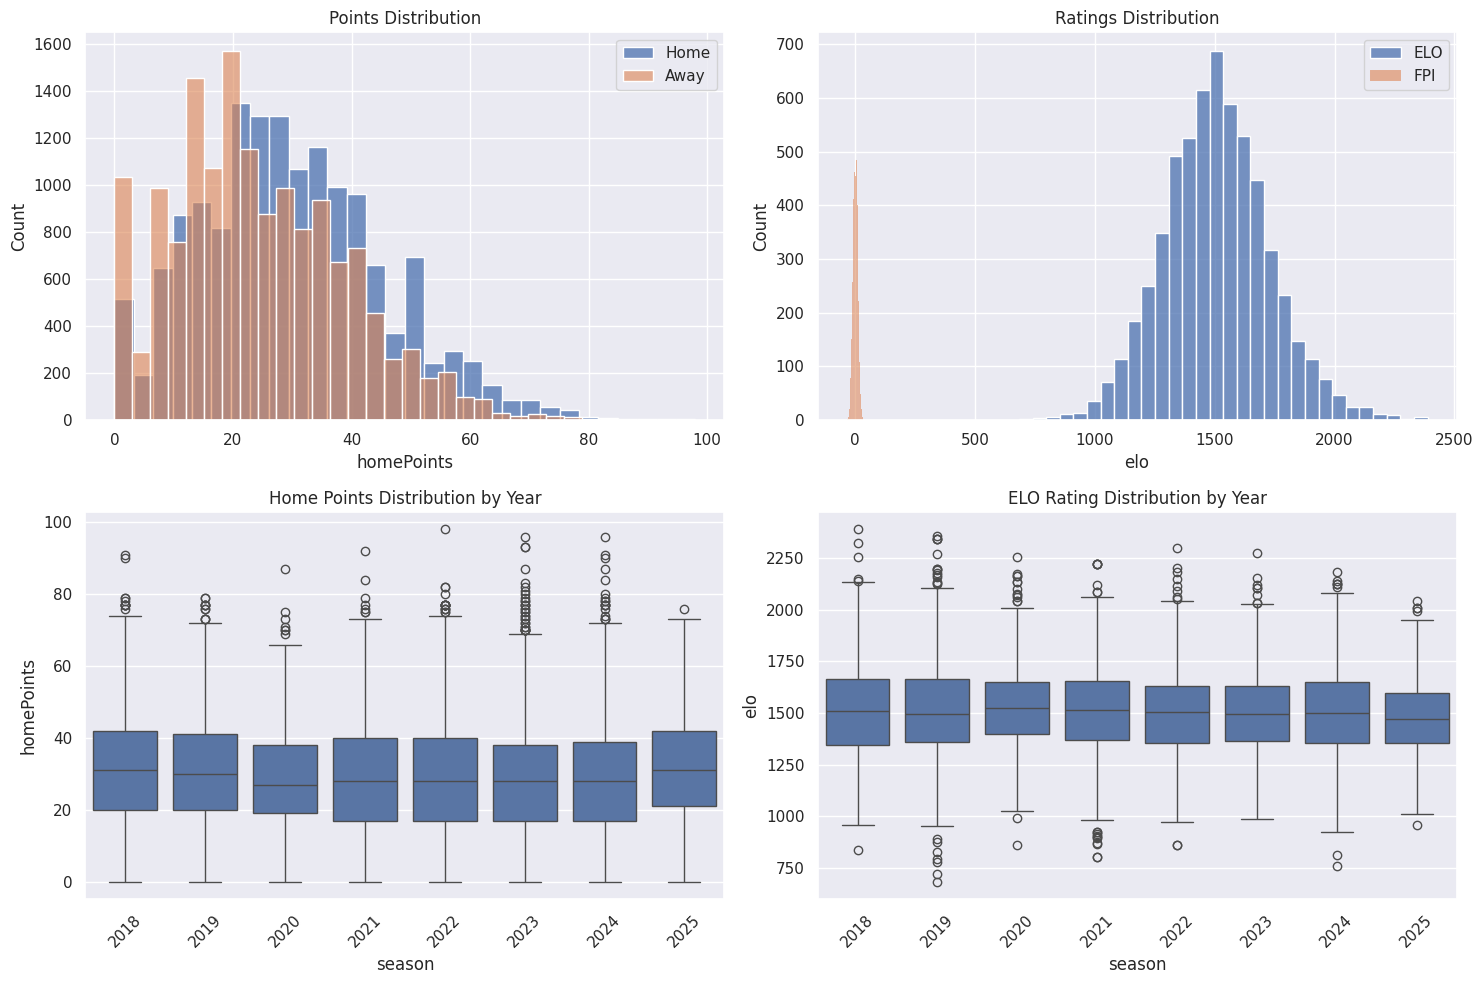


Memory Usage Analysis:
Total memory usage: 23.39 MB

Largest columns by memory usage:
awayLineScores    1.434158
homeLineScores    1.434158
awayTeam          0.985936
away_school       0.983920
homeTeam          0.982441
dtype: float64

Summary Statistics:
         homePoints    awayPoints          elo          fpi          srs
count  15036.000000  15036.000000  5926.000000  5899.000000  5193.000000
mean      29.634677     24.421189  1507.067415     0.407156     0.393339
std       15.693659     14.521975   220.122273     9.953657     9.685341
min        0.000000      0.000000   683.000000   -35.770000   -40.569229
25%       18.000000     14.000000  1360.000000    -6.865000    -6.492949
50%       28.000000     23.000000  1501.500000     0.332500     0.500000
75%       41.000000     34.000000  1646.500000     7.386500     7.228239
max       98.000000     91.000000  2388.000000    32.655000    34.190488

Rating Metrics Consistency Check:
Correlation between ELO and FPI: 0.952
Correlation

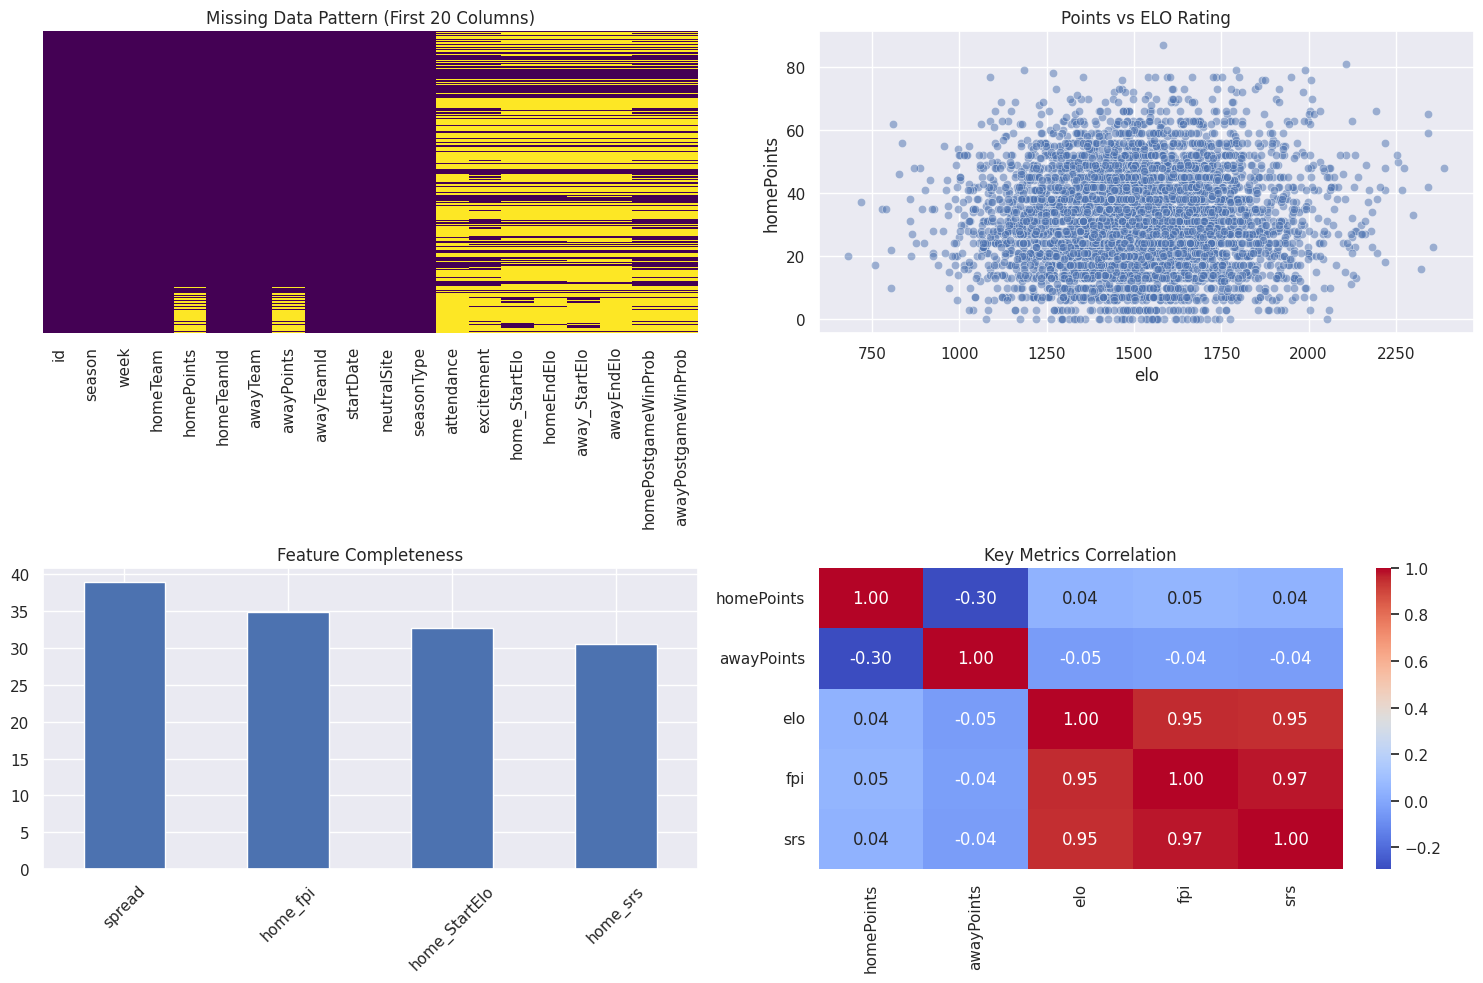

In [18]:
# Data quality checks after processing
print("\nData Quality Check:")
print("-" * 50)

# Check for key metrics completeness
key_metrics = ['epa', 'success', 'explosiveness', 'talent', 'elo', 'fpi', 'sp', 'srs']
print("\nKey Metrics Completeness:")
for metric in key_metrics:
    metric_cols = [col for col in games_df.columns if metric in col.lower()]
    for col in metric_cols:
        completeness = (1 - games_df[col].isnull().mean()) * 100
        print(f"{col}: {completeness:.1f}% complete")

# Verify temporal coverage
print("\nTemporal Coverage Analysis:")
agg_dict = {
    'id': 'count',
    'homePoints': ['mean', 'std'],
    'elo': ['mean', 'std'],
    'fpi': ['mean', 'std'],
    'srs': ['mean', 'std']
}

games_by_year = games_df.groupby('season').agg(agg_dict).round(2)
print(games_by_year)

# Check for potential duplicates
potential_dupes = games_df.groupby(['homeTeam', 'awayTeam', 'week', 'season']).size()
if (potential_dupes > 1).any():
    print("\nWarning: Found potential duplicate games!")
    print(potential_dupes[potential_dupes > 1])

# Verify feature engineering results
print("\nFeature Engineering Verification:")
rolling_features = [col for col in games_df.columns if 'rolling' in col]
h2h_features = [col for col in games_df.columns if 'h2h' in col]
streak_features = [col for col in games_df.columns if 'streak' in col]
rating_features = [col for col in games_df.columns if any(x in col.lower() for x in ['elo', 'fpi', 'sp', 'srs'])]

print(f"\nTotal rolling features: {len(rolling_features)}")
if rolling_features:
    print("Sample rolling features:", rolling_features[:5])
print(f"\nTotal h2h features: {len(h2h_features)}")
if h2h_features:
    print("H2H features:", h2h_features)
print(f"\nTotal streak features: {len(streak_features)}")
if streak_features:
    print("Streak features:", streak_features)
print(f"\nTotal rating features: {len(rating_features)}")
if rating_features:
    print("Sample rating features:", rating_features[:5])

# Quick correlation analysis with target variables
target_vars = ['homePoints', 'awayPoints']
numeric_cols = games_df.select_dtypes(include=[np.number]).columns

correlations = {}
for target in target_vars:
    if target in games_df.columns:
        correlations[target] = games_df[numeric_cols].corrwith(games_df[target]).sort_values(ascending=False)

print("\nTop correlations with points:")
for target, corrs in correlations.items():
    print(f"\n{target}:")
    print(corrs.head(10))

# Enhanced visualizations
plt.figure(figsize=(15, 10))

# Points distribution
plt.subplot(221)
sns.histplot(data=games_df['homePoints'].dropna(), bins=30, label='Home')
sns.histplot(data=games_df['awayPoints'].dropna(), bins=30, label='Away', alpha=0.6)
plt.title('Points Distribution')
plt.legend()

# Ratings distributions
plt.subplot(222)
if 'elo' in games_df.columns:
    sns.histplot(data=games_df['elo'].dropna(), bins=30, label='ELO')
if 'fpi' in games_df.columns:
    sns.histplot(data=games_df['fpi'].dropna(), bins=30, label='FPI', alpha=0.6)
plt.title('Ratings Distribution')
plt.legend()

# Points by year
plt.subplot(223)
sns.boxplot(data=games_df, x='season', y='homePoints')
plt.title('Home Points Distribution by Year')
plt.xticks(rotation=45)

# Ratings by year
plt.subplot(224)
if 'elo' in games_df.columns:
    sns.boxplot(data=games_df, x='season', y='elo')
    plt.title('ELO Rating Distribution by Year')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Memory usage analysis
memory_usage = games_df.memory_usage(deep=True) / 1024**2  # Convert to MB
print("\nMemory Usage Analysis:")
print(f"Total memory usage: {memory_usage.sum():.2f} MB")
print("\nLargest columns by memory usage:")
print(memory_usage.sort_values(ascending=False).head())

# Enhanced summary statistics with ratings
eff_bases = [
    'fpiOffensiveEfficiency',
    'fpiDefensiveEfficiency',
    'fpiSpecialTeamsEfficiency'
]

base_cols = ['homePoints', 'awayPoints', 'elo', 'fpi', 'srs']

# Use the _mean columns you just built
eff_mean_cols = [f'{b}_mean' for b in eff_bases if f'{b}_mean' in games_df.columns]

cols_to_summarize = [c for c in base_cols if c in games_df.columns] + eff_mean_cols

summary_stats = games_df[cols_to_summarize].describe()
print("\nSummary Statistics:")
print(summary_stats)


# Additional analysis of rating metrics consistency
print("\nRating Metrics Consistency Check:")
rating_pairs = [('elo', 'fpi'), ('fpi', 'srs'), ('elo', 'srs')]
for rat1, rat2 in rating_pairs:
    if rat1 in games_df.columns and rat2 in games_df.columns:
        correlation = games_df[rat1].corr(games_df[rat2])
        print(f"Correlation between {rat1.upper()} and {rat2.upper()}: {correlation:.3f}")

# Keep your existing imports and initial checks

# Add the new quality check functions first
def check_data_quality(games_df):
    """Run comprehensive data quality checks with handling for unhashable types"""
    quality_report = {}
    
    # Basic metrics (excluding duplicate check for unhashable types)
    quality_report['basic_metrics'] = {
        'total_rows': len(games_df),
        'total_columns': len(games_df.columns)
    }
    
    # Check duplicates only on hashable columns
    hashable_cols = [col for col in games_df.columns 
                    if games_df[col].dtype != 'object' or 
                    not games_df[col].apply(lambda x: isinstance(x, (list, dict))).any()]
    
    quality_report['basic_metrics']['duplicate_rows'] = games_df[hashable_cols].duplicated().sum()
    quality_report['basic_metrics']['memory_usage_mb'] = games_df.memory_usage(deep=True).sum() / 1024**2
    
    # Missing value analysis
    missing_data = pd.DataFrame({
        'missing_count': games_df.isnull().sum(),
        'missing_percentage': (games_df.isnull().sum() / len(games_df) * 100).round(2)
    }).sort_values('missing_percentage', ascending=False)
    quality_report['missing_data'] = missing_data[missing_data['missing_count'] > 0]
    
    # Column type analysis
    quality_report['column_types'] = {
        'numeric': len(games_df.select_dtypes(include=['int64', 'float64']).columns),
        'categorical': len(games_df.select_dtypes(include=['object', 'category']).columns),
        'datetime': len(games_df.select_dtypes(include=['datetime64']).columns),
        'other': len(games_df.select_dtypes(exclude=['int64', 'float64', 'object', 'category', 'datetime64']).columns)
    }
    
    # Check outliers for numeric columns
    numeric_cols = games_df.select_dtypes(include=['int64', 'float64']).columns
    outliers_report = {}
    for col in numeric_cols:
        Q1 = games_df[col].quantile(0.25)
        Q3 = games_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = len(games_df[(games_df[col] < (Q1 - 1.5 * IQR)) | 
                               (games_df[col] > (Q3 + 1.5 * IQR))])
        
        # Fix: Calculate percentage and round after
        percentage = float(outliers) / len(games_df) * 100
        outliers_report[col] = {
            'outliers_count': outliers,
            'outliers_percentage': round(percentage, 2)
        }
    quality_report['outliers'] = outliers_report
    
    return quality_report

# Usage remains the same:
quality_report = check_data_quality(games_df)

print("\nBasic Metrics:")
print("-" * 50)
for metric, value in quality_report['basic_metrics'].items():
    print(f"{metric}: {value}")

print("\nColumn Types:")
print("-" * 50)
for type_name, count in quality_report['column_types'].items():
    print(f"{type_name}: {count}")

print("\nOutliers Analysis:")
print("-" * 50)
for col, stats in quality_report['outliers'].items():
    if stats['outliers_count'] > 0:
        print(f"{col}: {stats['outliers_count']} outliers ({stats['outliers_percentage']:.2f}%)")

# Then, after your existing quality checks, add:
print("\nRunning Enhanced Quality Checks...")
quality_report = check_data_quality(games_df)

print("\nBasic Metrics:")
print("-" * 50)
for metric, value in quality_report['basic_metrics'].items():
    print(f"{metric}: {value}")

print("\nMissing Data Analysis:")
print("-" * 50)
print(quality_report['missing_data'])

# Enhanced visualizations - add after your existing plots
plt.figure(figsize=(15, 10))

# Missing data heatmap
plt.subplot(221)
sns.heatmap(games_df[games_df.columns[:20]].isnull(), 
            yticklabels=False, 
            cbar=False,
            cmap='viridis')
plt.title('Missing Data Pattern (First 20 Columns)')

# Points vs Ratings scatter
plt.subplot(222)
if 'elo' in games_df.columns and 'homePoints' in games_df.columns:
    sns.scatterplot(data=games_df, x='elo', y='homePoints', alpha=0.5)
plt.title('Points vs ELO Rating')

# Feature completeness
plt.subplot(223)
# Fix: Only use metrics that exist in the dataframe
available_metrics = []
for metric in key_metrics:
    metric_cols = [col for col in games_df.columns if metric in col.lower()]
    available_metrics.extend(metric_cols[:1])  # Take first instance of each metric type

available_metrics = list(set(available_metrics))  # Remove duplicates
if available_metrics:
    completeness = (1 - games_df[available_metrics].isnull().mean()) * 100
    completeness.plot(kind='bar')
    plt.title('Feature Completeness')
    plt.xticks(rotation=45)

# Correlation heatmap
plt.subplot(224)
key_numeric_cols = ['homePoints', 'awayPoints', 'elo', 'fpi', 'srs']
available_numeric_cols = [col for col in key_numeric_cols if col in games_df.columns]
if available_numeric_cols:
    sns.heatmap(games_df[available_numeric_cols].corr(), 
                annot=True, 
                cmap='coolwarm',
                fmt='.2f')
plt.title('Key Metrics Correlation')

plt.tight_layout()
plt.show()

# Feature Engineering

In [19]:
BASE_RF_CONFIG = {
    'n_estimators': 500,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'random_state': 42,
    'n_jobs': -1
}

def add_team_performance_context(df):
   """Add team performance context features"""
   df = df.copy()
   
   for team_type in ['home', 'away']:
       team_id_col = f'{team_type}TeamId'
       points_col = f'{team_type}Points'
       
       # Historical scoring
       df[f'{team_type}_historical_scoring'] = df.groupby(team_id_col)[points_col].transform(
           lambda x: x.expanding().mean()
       )
       
       # Last 3/5 game averages
       for window in [3, 5]:
           df[f'{team_type}_last{window}_avg'] = df.groupby(team_id_col)[points_col].transform(
               lambda x: x.rolling(window, min_periods=1).mean()
           )
           
       # Season stats
       df[f'{team_type}_season_avg'] = df.groupby([team_id_col, 'season'])[points_col].transform('mean')
       df[f'{team_type}_season_std'] = df.groupby([team_id_col, 'season'])[points_col].transform('std')
       
       # Win/Loss records
       if f'{team_type}_won' not in df.columns:
           opp_type = 'away' if team_type == 'home' else 'home' 
           df[f'{team_type}_won'] = (df[points_col] > df[f'{opp_type}Points']).astype(int)
           
       # Conference performance
       df[f'{team_type}_conf_win_pct'] = df.groupby(
           ['season', f'{team_type}_conference'])[f'{team_type}_won'].transform('mean')
           
       # Home/Away splits
       df[f'{team_type}_venue_scoring'] = df.groupby([team_id_col, 'season'])[points_col].transform(
           lambda x: x.expanding().mean()
       )
       
   # Conference matchups
   df['conf_vs_conf_history'] = df.groupby(['home_conference', 'away_conference'])['home_won'].transform('mean')
   
   return df

def add_enhanced_timing_features(df):
   """Add timing-related features"""
   df = df.copy()
   
   # Season context
   df['games_into_season'] = df.groupby(['season', 'homeTeamId']).cumcount()
   df['games_remaining'] = df.groupby('season')['week'].transform('max') - df['week']
   df['season_progress'] = df['week'] / df.groupby('season')['week'].transform('max')
   
   # Rest days
   if all(col in df.columns for col in ['home_rest_days', 'away_rest_days']):
       df['rest_advantage'] = df['home_rest_days'] - df['away_rest_days']
       df['total_rest'] = df['home_rest_days'] + df['away_rest_days']
       
       # Flag short/long rest
       df['home_short_rest'] = (df['home_rest_days'] < 6).astype(int)
       df['away_short_rest'] = (df['away_rest_days'] < 6).astype(int)
       df['home_long_rest'] = (df['home_rest_days'] > 8).astype(int)
       df['away_long_rest'] = (df['away_rest_days'] > 8).astype(int)
   
   # Game importance
   if 'excitement' in df.columns:
       df['rivalry_game'] = df.groupby(['homeTeamId', 'awayTeamId'])['excitement'].transform(
           lambda x: x > x.mean() + x.std()
       ).astype(int)
       
       df['big_game'] = df['excitement'] > df['excitement'].quantile(0.75)
       
   return df

def add_enhanced_momentum_features(df):
   """Add comprehensive momentum features"""
   df = df.copy()
   df = df.sort_values(['startDate', 'homeTeamId'])  
   
   for team_type in ['home', 'away']:
       points_col = f'{team_type}Points'
       team_id_col = f'{team_type}TeamId'
       opp_type = 'away' if team_type == 'home' else 'home'
       
       df[points_col] = pd.to_numeric(df[points_col], errors='coerce')
       
       # Short/long-term scoring
       for window in [3, 6]:
           df[f'{team_type}_points_last{window}'] = df.groupby([team_id_col, 'season'])[points_col].transform(
               lambda x: x.astype(float).rolling(window, min_periods=1).mean()
           )
           
       # Point trends
       df[f'{team_type}_points_momentum'] = (
           df[f'{team_type}_points_last3'] - df[f'{team_type}_points_last6']
       )
       
       # Win/Loss records
       df[f'{team_type}_won'] = (
           df[points_col] > df[f'{opp_type}Points']
       ).astype(int)
       
       # Point differential and scoring efficiency 
       df[f'{team_type}_point_diff'] = df[points_col] - df[f'{opp_type}Points']
       df[f'{team_type}_scoring_efficiency'] = df[points_col] / df.groupby([team_id_col, 'season'])[points_col].transform('mean')
       
       # Weighted recent performance
       df[f'{team_type}_win_quality'] = df.groupby([team_id_col, 'season']).apply(
           lambda x: (
               x[f'{team_type}_point_diff'] * 
               x[f'{team_type}_won'] * 
               np.exp(-np.arange(len(x))[::-1]/3)  # Exponential decay
           ).rolling(3, min_periods=1).mean()
       ).reset_index(level=[0,1], drop=True)
       
       # Form indicators
       df[f'{team_type}_in_form'] = (
           df[f'{team_type}_points_momentum'] > 0
       ).astype(int)
       
   return df

def add_sos_features(df):
    """Add strength-of-schedule features using normalized columns:
       home_* / away_* for ratings, and home_StartElo / away_StartElo for Elo.
    """
    df = df.copy()

    def pick_col(side: str, base: str):
        """Return the correct column name if present, trying both with and without underscore."""
        candidates = [f'{side}_{base}', f'{side}{base}']
        for c in candidates:
            if c in df.columns:
                return c
        return None  # not found

    for team_type in ['home', 'away']:
        team_id_col = f'{team_type}TeamId'
        opp_type = 'away' if team_type == 'home' else 'home'

        # Opponent strength (expanding mean of opponent ratings)
        for base in ['StartElo', 'fpi', 'srs']:
            opp_col = pick_col(opp_type, base)
            if opp_col:
                df[f'{team_type}_opponent_{base.lower()}'] = (
                    df.groupby([team_id_col, 'season'])[opp_col]
                      .transform(lambda x: x.expanding().mean())
                )

        # Conference strength (mean opponent ratings within conference-season)
        conf_col = f'{team_type}_conference'
        if conf_col in df.columns:
            opp_startelo = pick_col(opp_type, 'StartElo')
            opp_fpi     = pick_col(opp_type, 'fpi')
            opp_srs     = pick_col(opp_type, 'srs')

            if opp_startelo:
                df[f'{team_type}_conf_elo'] = df.groupby([conf_col, 'season'])[opp_startelo].transform('mean')
            if opp_fpi:
                df[f'{team_type}_conf_fpi'] = df.groupby([conf_col, 'season'])[opp_fpi].transform('mean')
            if opp_srs:
                df[f'{team_type}_conf_srs'] = df.groupby([conf_col, 'season'])[opp_srs].transform('mean')

            # Conference rank (higher ELO => better)
            if f'{team_type}_conf_elo' in df.columns:
                df[f'{team_type}_conf_rank'] = df.groupby('season')[f'{team_type}_conf_elo'].rank(ascending=False)

    return df



def add_interaction_features(df):
   """Add interaction terms between features"""
   df = df.copy()
   
   # Team comparisons
   if all(col in df.columns for col in ['home_points_momentum', 'away_points_momentum']):
       df['momentum_diff'] = df['home_points_momentum'] - df['away_points_momentum']
       
   if all(col in df.columns for col in ['home_win_quality', 'away_win_quality']):
       df['quality_diff'] = df['home_win_quality'] - df['away_win_quality']
       
   # Conference interactions
   if all(col in df.columns for col in ['home_conf_rank', 'away_conf_rank']):
       df['conf_rank_diff'] = df['home_conf_rank'] - df['away_conf_rank']
       
   # Form interactions  
   if all(col in df.columns for col in ['home_in_form', 'away_in_form']):
       df['form_advantage'] = df['home_in_form'] - df['away_in_form']
   
   # Rest impact
   if 'rest_advantage' in df.columns:
       for col in ['momentum_diff', 'quality_diff']:
           if col in df.columns:
               df[f'rest_{col}'] = df['rest_advantage'] * df[col]
               
   # Season context
   if 'season_progress' in df.columns:
       for col in ['momentum_diff', 'quality_diff', 'conf_rank_diff']:
           if col in df.columns:
               df[f'season_prog_{col}'] = df['season_progress'] * df[col]
   
   return df

def add_enhanced_features(df):
   """Master feature engineering function"""
   enhanced_df = df.copy()
   enhanced_df['startDate'] = pd.to_datetime(enhanced_df['startDate'])

   print("Adding team performance context...")
   enhanced_df = add_team_performance_context(enhanced_df)
   
   print("Adding timing features...")  
   enhanced_df = add_enhanced_timing_features(enhanced_df)
   
   print("Adding momentum features...")
   enhanced_df = add_enhanced_momentum_features(enhanced_df)
   
   print("Adding strength of schedule features...")
   enhanced_df = add_sos_features(enhanced_df)
   
   print("Adding feature interactions...")
   enhanced_df = add_interaction_features(enhanced_df)
   
   # Add season context
   if len(df) > 0:
       enhanced_df['season_period'] = pd.qcut(df['week'], q=3, labels=['Early', 'Mid', 'Late'])
   else:
       enhanced_df['season_period'] = 'Mid'
       
   # Add expected scoring
   if 'overUnder' in df.columns:
       enhanced_df['expected_scoring'] = df['overUnder'].fillna(df['overUnder'].mean())
       
       if 'fpiOffensiveEfficiency' in df.columns:
           enhanced_df['scoring_efficiency_interaction'] = (
               enhanced_df['expected_scoring'] * 
               df['fpiOffensiveEfficiency'] * 
               np.where(df['homeTeam'].notna(), 1.1, 1.0)
           )
           
   return enhanced_df

def create_conference_models(X_train, y_train, is_home=True):
    """Create separate models for each conference"""
    conf_models = {}
    conf_col = 'home_conference_encoded' if is_home else 'away_conference_encoded'
    
    for conf_id in X_train[conf_col].unique():
        mask = X_train[conf_col] == conf_id
        if mask.sum() > 100:
            X_conf = X_train[mask]
            y_conf = y_train[mask]
            model = RandomForestRegressor(**BASE_RF_CONFIG)
            try:
                model.fit(X_conf, y_conf)
                conf_models[conf_id] = {
                    'model': model,
                    'samples': len(X_conf),
                    'features': X_conf.shape[1]
                }
            except Exception as e:
                print(f"Error training conference model {conf_id}: {str(e)}")
    return conf_models

def create_seasonal_models(X_train, y_train, week_col='week'):
    """Create separate models for different parts of season"""
    bins = pd.qcut(X_train[week_col].astype(float), q=3, labels=False)
    period_models = {}
    
    for period_idx, period_name in enumerate(['Early', 'Mid', 'Late']):
        mask = bins == period_idx
        if mask.sum() > 100:
            X_period = X_train[mask]
            y_period = y_train[mask]
            model = RandomForestRegressor(**BASE_RF_CONFIG)
            try:
                model.fit(X_period, y_period)
                period_models[period_name] = {
                    'model': model,
                    'samples': len(X_period),
                    'features': X_period.shape[1]
                }
            except Exception as e:
                print(f"Error training {period_name} season model: {str(e)}")
    return period_models

def create_yearly_models(X_train, y_train, is_home=True):
    """Create separate models for each year"""
    yearly_models = {}
    for year in sorted(X_train['season'].unique()):
        mask = X_train['season'] == year
        if mask.sum() > 100:
            X_year = X_train[mask]
            y_year = y_train[mask]
            model = RandomForestRegressor(**BASE_RF_CONFIG)
            imputer = SimpleImputer(strategy='median')
            X_year_imputed = imputer.fit_transform(X_year)
            try:
                model.fit(X_year_imputed, y_year)
                yearly_models[year] = {
                    'model': model,
                    'imputer': imputer,
                    'samples': len(X_year),
                    'features': X_year.shape[1]
                }
            except Exception as e:
                print(f"Error training {year} model: {str(e)}")
    return yearly_models

def evaluate_predictions(y_true, y_pred, prefix=''):
    """Calculate evaluation metrics"""
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }
    diff = np.abs(y_true - y_pred)
    for margin in [3, 7, 10, 14]:
        metrics[f'within_{margin}'] = (diff <= margin).mean()
    return metrics

def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a single model"""
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    model.fit(X_train_imputed, y_train)
    return {
        'model': model,
        'imputer': imputer,
        'train_metrics': evaluate_predictions(y_train, model.predict(X_train_imputed)),
        'test_metrics': evaluate_predictions(y_test, model.predict(X_test_imputed)),
        'train_predictions': model.predict(X_train_imputed),
        'test_predictions': model.predict(X_test_imputed)
    }

def create_stratified_season_split(df, test_size=0.2, random_state=42):
    """Create train/test splits preserving season structure"""
    train_mask = pd.Series(False, index=df.index)
    test_mask = pd.Series(False, index=df.index)
    
    for season in df['season'].unique():
        season_mask = df['season'] == season
        season_weeks = df[season_mask]['week'].unique()
        n_test_weeks = max(1, int(len(season_weeks) * test_size))
        
        np.random.seed(random_state + season)
        test_weeks = np.random.choice(season_weeks, size=n_test_weeks, replace=False)
        
        train_mask |= season_mask & ~df['week'].isin(test_weeks)
        test_mask |= season_mask & df['week'].isin(test_weeks)
    
    return train_mask, test_mask

from sklearn.impute import SimpleImputer

def _align_features(df, ref_cols):
    """Return df with columns in ref_cols order; add any missing as 0."""
    df2 = df.copy()
    for c in ref_cols:
        if c not in df2.columns:
            df2[c] = 0.0
    # Keep only the ref columns and order them
    return df2[ref_cols]

def evaluate_yearly_models(yearly_models: dict, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """
    Evaluate each per-year model on the matching year’s rows from X_test/y_test.
    Assumes X_test is already preprocessed (encoded/imputed-ready) and includes a 'season' column.
    """
    results = {}

    # If season got cast to float during preprocessing, normalize to int for comparison
    season_col = 'season'
    if season_col in X_test.columns and not pd.api.types.is_integer_dtype(X_test[season_col]):
        # don’t mutate caller’s frame
        X_test = X_test.copy()
        X_test[season_col] = X_test[season_col].astype(float).round().astype(int)

    for year, bundle in yearly_models.items():
        model = bundle['model']
        imputer = bundle.get('imputer', None)

        # Select test rows for this year
        if season_col not in X_test.columns:
            # No season column available in features => we can’t evaluate per-year
            continue
        mask = (X_test[season_col].astype(int) == int(year))
        if mask.sum() == 0:
            continue

        Xy = X_test.loc[mask]
        yy = y_test.loc[Xy.index]

        # Align columns to what the model was trained on
        if hasattr(model, 'feature_names_in_'):
            ref_cols = list(model.feature_names_in_)
            Xy = _align_features(Xy, ref_cols)

        # Impute with the per-year imputer (fit during training)
        if imputer is not None:
            Xy_imp = imputer.transform(Xy)
        else:
            # Fallback imputer if something went odd
            fallback = SimpleImputer(strategy='median')
            Xy_imp = fallback.fit_transform(Xy)

        y_pred = model.predict(Xy_imp)
        metrics = evaluate_predictions(yy.values, y_pred)
        results[year] = metrics

    return results


def prepare_features(data, encoders=None):
   """Prepare features for model input"""
   try:
       data = data.copy()
       
       # Features to exclude
       exclude_cols = [
           'homePoints', 'awayPoints', 'homeTeam', 'awayTeam', 'homeTeamId',
           'awayTeamId', 'startDate', 'id', 'gameId', 'awayLineScores',
           'homeLineScores', 'homeEndElo', 'awayEndElo', 'homePostgameWinProb',
           'awayPostgameWinProb', 'away_won', 'home_won'
       ]
       
       # Handle missing values
       for col in data.columns:
           if col in exclude_cols:
               continue
           elif any(x in col.lower() for x in ['rolling', 'elo', 'fpi', 'sp', 'srs']):
               data[col] = data[col].fillna(method='ffill').fillna(method='bfill')
           elif 'days_rest' in col.lower():
               data[col] = data[col].fillna(7)  
           elif any(x in col.lower() for x in ['streak', 'h2h', 'win', 'momentum', 'quality', 'sos']):
               data[col] = data[col].fillna(0)
           elif any(x in col.lower() for x in ['historical', 'venue']):
               data[col] = data[col].fillna(data[col].mean())
       
       # Prepare feature sets
       features_df = data[[col for col in data.columns if col not in exclude_cols]].copy()
       numeric_cols = features_df.select_dtypes(include=['int64', 'float64']).columns
       categorical_cols = features_df.select_dtypes(include=['object']).columns
       
       encoded_data = features_df[numeric_cols].copy()
       current_encoders = encoders or {}
       
       # Encode categorical features
       for col in categorical_cols:
           col_data = features_df[col].fillna('unknown').astype(str)
           
           if encoders is None:
               encoder = LabelEncoder()
               encoder.fit(np.append(col_data.unique(), 'unknown'))
               current_encoders[col] = encoder
           else:
               encoder = encoders[col]
               col_data = pd.Series(
                   np.where(~col_data.isin(encoder.classes_), 'unknown', col_data),
                   index=col_data.index
               )
               
           encoded_data[f'{col}_encoded'] = encoder.transform(col_data)
           
       encoded_data = encoded_data.fillna(encoded_data.median())
       
       return (encoded_data, current_encoders) if encoders is None else encoded_data
       
   except Exception as e:
       print(f"Error preparing features: {str(e)}")
       raise

print("\nCreating enhanced_df...")
enhanced_df = add_enhanced_features(games_df)


Creating enhanced_df...
Adding team performance context...
Adding timing features...
Adding momentum features...
Adding strength of schedule features...
Adding feature interactions...


# Model Training

In [20]:
def train_models(enhanced_df, TRAIN_SIZE=0.8, RANDOM_STATE=42):
    # Model configurations


    base_models = {
        'rf': RandomForestRegressor(**BASE_RF_CONFIG),
        'gbm': GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            random_state=RANDOM_STATE
        ),
        'xgb': XGBRegressor(
            n_estimators=500, 
            max_depth=8,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    }

    # Prepare data splits
    home_data = prepare_team_data(enhanced_df, 'home', TRAIN_SIZE)
    X_home_train, X_home_test, y_home_train, y_home_test, home_encoders = home_data
    
    away_data = prepare_team_data(enhanced_df, 'away', TRAIN_SIZE, home_encoders)
    X_away_train, X_away_test, y_away_train, y_away_test, _ = away_data
    
    # Train models
    results = {'home': {}, 'away': {}}
    
    for model_type, base_model in base_models.items():
        # Train home model
        home_model = train_evaluate_model(
            base_model, X_home_train, X_home_test, 
            y_home_train, y_home_test, f"Home-{model_type}"
        )
        results['home'][model_type] = home_model

        # Train away model  
        away_model = train_evaluate_model(
            clone(base_model), X_away_train, X_away_test,
            y_away_train, y_away_test, f"Away-{model_type}" 
        )
        results['away'][model_type] = away_model

    # Train specialized models with clean data
    conf_models = {
        'home': create_conference_models(X_home_train, y_home_train, True),
        'away': create_conference_models(X_away_train, y_away_train, False)
    }
    
    season_models = {
        'home': create_seasonal_models(X_home_train, y_home_train),
        'away': create_seasonal_models(X_away_train, y_away_train)
    }
    
    yearly_models = {
        'home': create_yearly_models(X_home_train, y_home_train, True),
        'away': create_yearly_models(X_away_train, y_away_train, False)
    }
    
    # Evaluate yearly models
    yearly_metrics = {
        'home': evaluate_yearly_models(yearly_models['home'], X_home_test, y_home_test),
        'away': evaluate_yearly_models(yearly_models['away'], X_away_test, y_away_test)
    }

    # Compile model info
    model_info = {
        'models': {
            'home': {'rf': results['home']['rf']},
            'away': {'rf': results['away']['rf']}
        },
        'performances': summarize_performances(results),
        'encoders': home_encoders,
        'features': X_home_train.columns.tolist(),
        'specialized_models': {
            'conference': conf_models,
            'seasonal': season_models,
            'yearly': yearly_models,
            'yearly_metrics': yearly_metrics
        }
    }
    
    print_performance_summary(model_info)
    return model_info

def prepare_team_data(enhanced_df, team_type, train_size, encoders=None):
    """Prepare data for modeling"""
    team_id_col = f'{team_type}TeamId'
    points_col = f'{team_type}Points'
    
    # Filter out invalid rows
    valid_idx = (enhanced_df[points_col].notna()) & (enhanced_df[team_id_col].notna())
    X = enhanced_df[valid_idx].copy()
    y = X[points_col].copy()
    
    # Split train/test
    train_mask, test_mask = create_stratified_season_split(X, 1-train_size)
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    # Prepare features
    if encoders is None:
        X_train_prep, encoders = prepare_features(X_train)
        X_test_prep = prepare_features(X_test, encoders)
    else:
        X_train_prep = prepare_features(X_train, encoders) 
        X_test_prep = prepare_features(X_test, encoders)
        
    return X_train_prep, X_test_prep, y_train, y_test, encoders

def summarize_performances(results):
   """Summarize model performances"""
   performances = {'home': {}, 'away': {}}
   
   for team_type in ['home', 'away']:
       for name, res in results[team_type].items():
           if isinstance(res, dict) and 'test_metrics' in res:
               metrics = res['test_metrics']
               performances[team_type][name] = {
                   'rmse': metrics['rmse'],
                   'mae': metrics['mae'], 
                   'r2': metrics['r2'],
                   'within_7': metrics['within_7'],
                   'within_10': metrics['within_10']
               }
   
   return performances

def print_performance_summary(model_info):
   """Print model performance summary"""
   for point_type in ['home', 'away']:
       print(f"\n{point_type.capitalize()} Models Performance:")
       for model_name, metrics in model_info['performances'][point_type].items():
           print(f"\n{model_name.upper()}:")
           print(f"RMSE: {metrics['rmse']:.2f}")
           print(f"MAE: {metrics['mae']:.2f}") 
           print(f"R² Score: {metrics['r2']:.2f}")
           print(f"Within 7: {metrics['within_7']:.1%}")
           print(f"Within 10: {metrics['within_10']:.1%}")
           
   for point_type in ['home', 'away']:
       if model_info['specialized_models']['yearly_metrics'][point_type]:
           print(f"\n{point_type.title()} Yearly Performance:")
           metrics = model_info['specialized_models']['yearly_metrics'][point_type]
           for year, year_metrics in metrics.items():
               print(f"\nYear {year}:")
               print(f"RMSE: {year_metrics['rmse']:.2f}")
               print(f"MAE: {year_metrics['mae']:.2f}")
               print(f"R²: {year_metrics['r2']:.2f}")

# Execute training
model_info = train_models(enhanced_df)


Home Models Performance:

RF:
RMSE: 1.19
MAE: 0.55
R² Score: 0.99
Within 7: 99.6%
Within 10: 99.8%

GBM:
RMSE: 0.76
MAE: 0.47
R² Score: 1.00
Within 7: 99.9%
Within 10: 100.0%

XGB:
RMSE: 0.95
MAE: 0.61
R² Score: 1.00
Within 7: 99.8%
Within 10: 100.0%

Away Models Performance:

RF:
RMSE: 1.02
MAE: 0.42
R² Score: 1.00
Within 7: 99.6%
Within 10: 99.9%

GBM:
RMSE: 0.61
MAE: 0.37
R² Score: 1.00
Within 7: 100.0%
Within 10: 100.0%

XGB:
RMSE: 0.87
MAE: 0.56
R² Score: 1.00
Within 7: 99.9%
Within 10: 100.0%

Home Yearly Performance:

Year 2018:
RMSE: 2.49
MAE: 1.39
R²: 0.98

Year 2019:
RMSE: 2.16
MAE: 1.23
R²: 0.98

Year 2020:
RMSE: 2.50
MAE: 1.58
R²: 0.97

Year 2021:
RMSE: 1.44
MAE: 0.79
R²: 0.99

Year 2022:
RMSE: 2.55
MAE: 1.37
R²: 0.98

Year 2023:
RMSE: 2.98
MAE: 1.73
R²: 0.96

Year 2024:
RMSE: 2.78
MAE: 1.69
R²: 0.97

Year 2025:
RMSE: 4.60
MAE: 2.70
R²: 0.93

Away Yearly Performance:

Year 2018:
RMSE: 1.73
MAE: 0.94
R²: 0.99

Year 2019:
RMSE: 1.89
MAE: 0.98
R²: 0.98

Year 2020:
RMSE: 2.55


# Model Evaluation

In [21]:
# Model Evaluation Functions

def validate_predictions(results, y_home_test, y_away_test):
   """Validate model predictions vs actuals"""
   home_preds = results['home']['rf']['test_predictions'] 
   away_preds = results['away']['rf']['test_predictions']
   
   print("\nPrediction Stats:")
   print(f"Home - Predicted avg: {home_preds.mean():.1f} (Actual: {y_home_test.mean():.1f})")
   print(f"Away - Predicted avg: {away_preds.mean():.1f} (Actual: {y_away_test.mean():.1f})")
   print(f"Home advantage: {(home_preds - away_preds).mean():.1f} (Actual: {(y_home_test - y_away_test).mean():.1f})")
   
   print("\nRanges:")
   print(f"Home predictions: {home_preds.min():.1f} to {home_preds.max():.1f}")
   print(f"Home actuals: {y_home_test.min():.1f} to {y_home_test.max():.1f}")
   print(f"Away predictions: {away_preds.min():.1f} to {away_preds.max():.1f}") 
   print(f"Away actuals: {y_away_test.min():.1f} to {y_away_test.max():.1f}")
   
   unrealistic = {
       'home': sum((home_preds < 0) | (home_preds > 100)),
       'away': sum((away_preds < 0) | (away_preds > 100))
   }
   print(f"\nUnrealistic scores (outside 0-100):")
   print(f"Home: {unrealistic['home']}")
   print(f"Away: {unrealistic['away']}")

def analyze_features_comprehensive(model, feature_names, top_n=20):
   """Analyze feature importance and feature groups"""
   if not hasattr(model, 'feature_importances_'):
       return None, None
       
   importances = pd.DataFrame({
       'feature': feature_names,
       'importance': model.feature_importances_
   }).sort_values('importance', ascending=False)
   
   feature_groups = {
       'Time-weighted': ['last3', 'season_weighted', 'trend', 'rolling', 'momentum'],
       'Team-specific': ['win_pct', 'conf_dominance', 'field_impact', 'road_perf', 'venue'],  
       'Base Stats': ['points', 'elo', 'fpi', 'epa', 'success'],
       'Context': ['week', 'season', 'rest', 'weather'],
       'Identity': ['team', 'school', 'conf', 'division']
   }
   
   group_importance = {}
   print("\nFeature Groups:")
   for group, keywords in feature_groups.items():
       mask = importances['feature'].str.contains('|'.join(keywords), case=False)
       group_importance[group] = importances[mask]['importance'].sum()
       print(f"{group}: {group_importance[group]:.4f}")
       
   plot_feature_importance_groups(importances, group_importance, top_n)
   return importances, group_importance
   
def plot_feature_importance_groups(importances, group_importance, top_n):
   """Plot feature importance analysis"""
   plt.figure(figsize=(15, 10))
   
   plt.subplot(2, 1, 1)
   plt.title('Top Features')
   sns.barplot(data=importances.head(top_n), x='importance', y='feature')
   
   plt.subplot(2, 1, 2) 
   plt.title('Feature Groups')
   group_df = pd.DataFrame({
       'group': list(group_importance.keys()),
       'importance': list(group_importance.values())
   }).sort_values('importance', ascending=False)
   sns.barplot(data=group_df, x='importance', y='group')
   
   plt.tight_layout()
   plt.show()

def plot_feature_importance(model, features, title, top_n=20):
   """Plot feature importance ranking"""
   if not hasattr(model, 'feature_importances_'):
       return None
       
   importance = pd.DataFrame({
       'feature': features,
       'importance': model.feature_importances_
   }).sort_values('importance', ascending=False)
   
   plt.figure(figsize=(12, 6))
   plt.title(title)
   sns.barplot(data=importance.head(top_n), x='importance', y='feature')
   plt.xlabel('Importance')
   plt.tight_layout()
   plt.show()
   
   return importance

def evaluate_spread_predictions(y_home, y_away, y_home_pred, y_away_pred): 
   """Evaluate spread and total predictions"""
   actual_spread = y_home - y_away
   pred_spread = y_home_pred - y_away_pred
   actual_total = y_home + y_away
   pred_total = y_home_pred + y_away_pred
   
   spread_metrics = {
       'rmse': np.sqrt(mean_squared_error(actual_spread, pred_spread)),
       'mae': mean_absolute_error(actual_spread, pred_spread),
       'directional_accuracy': (np.sign(actual_spread) == np.sign(pred_spread)).mean()
   }
   
   total_metrics = {
       'rmse': np.sqrt(mean_squared_error(actual_total, pred_total)),
       'mae': mean_absolute_error(actual_total, pred_total)
   }
   
   # Scoring brackets
   for low, high in [(0,35), (36,50), (51,65), (66,80), (81,100)]:
       mask = (actual_total >= low) & (actual_total <= high)
       if mask.sum() > 0:
           total_metrics[f'rmse_{low}_{high}'] = np.sqrt(mean_squared_error(
               actual_total[mask], pred_total[mask]
           ))
   
   print("\nSpread Metrics:") 
   for metric, value in spread_metrics.items():
       if 'accuracy' in metric:
           print(f"{metric.replace('_', ' ').title()}: {value:.1%}")
       else:
           print(f"{metric.upper()}: {value:.2f}")
   
   print("\nTotal Points Metrics:")
   print(f"RMSE: {total_metrics['rmse']:.2f}") 
   print(f"MAE: {total_metrics['mae']:.2f}")
   print("\nRMSE by Scoring Bracket:")
   for low, high in [(0,35), (36,50), (51,65), (66,80), (81,100)]:
       key = f'rmse_{low}_{high}'
       if key in total_metrics:
           print(f"{low}-{high} points: {total_metrics[key]:.2f}")
           
   return spread_metrics, total_metrics

def compare_model_feature_importance(home_importance, away_importance, home_groups, away_groups):
   """Compare home vs away model feature importance"""
   print("\nFeature Importance Comparison:")
   
   all_groups = sorted(set(home_groups) | set(away_groups))
   comparison_data = [{
       'group': group,
       'home_importance': home_groups.get(group, 0),
       'away_importance': away_groups.get(group, 0),
       'difference': home_groups.get(group, 0) - away_groups.get(group, 0)
   } for group in all_groups]
   
   comparison_df = pd.DataFrame(comparison_data).sort_values('difference', ascending=False)
   print("\nGroup Importance Differences:")
   print(comparison_df)
   
   plot_importance_comparisons(comparison_df, all_groups, home_importance, away_importance)
   
   compare_top_features(home_importance, away_importance)

def plot_importance_comparisons(comparison_df, all_groups, home_importance, away_importance):
   """Plot feature importance comparisons"""
   plt.figure(figsize=(15, 8))
   x = np.arange(len(all_groups))
   width = 0.35
   
   plt.bar(x - width/2, comparison_df['home_importance'], width, label='Home')
   plt.bar(x + width/2, comparison_df['away_importance'], width, label='Away')
   
   plt.xlabel('Feature Groups')
   plt.ylabel('Importance')
   plt.title('Group Importance: Home vs Away')
   plt.xticks(x, all_groups, rotation=45)
   plt.legend()
   plt.tight_layout()
   plt.show()
   
   plot_top_feature_comparison(home_importance, away_importance)

def compare_top_features(home_importance, away_importance):
   """Compare top features between models"""
   print("\nTop Feature Comparison:")
   top_features = pd.merge(
       home_importance.head(10).rename(columns={'importance': 'home_imp'}),
       away_importance.head(10).rename(columns={'importance': 'away_imp'}),
       on='feature',
       how='outer'
   ).fillna(0)
   
   top_features['diff'] = top_features['home_imp'] - top_features['away_imp']
   print("\nFeature Importance Differences:")
   print(top_features.sort_values('diff', ascending=False))
   
def plot_top_feature_comparison(home_importance, away_importance):
   """Plot top feature comparison"""
   plt.figure(figsize=(15, 8))
   
   features = list(set(home_importance.head(10)['feature']) | 
                  set(away_importance.head(10)['feature']))
                  
   home_vals = [home_importance[home_importance['feature'] == f]['importance'].iloc[0] 
                if f in home_importance['feature'].values else 0 for f in features]
   away_vals = [away_importance[away_importance['feature'] == f]['importance'].iloc[0]
                if f in away_importance['feature'].values else 0 for f in features]
   
   x = np.arange(len(features))
   width = 0.35
   plt.bar(x - width/2, home_vals, width, label='Home')
   plt.bar(x + width/2, away_vals, width, label='Away')
   
   plt.xlabel('Features')
   plt.ylabel('Importance')
   plt.title('Top Feature Importance: Home vs Away')
   plt.xticks(x, features, rotation=45, ha='right')
   plt.legend()
   plt.tight_layout()
   plt.show()

# Main evaluation code
def evaluate_models(results, model_info, X_home_train, y_home_test, y_away_test):
   """Run full model evaluation"""
   validate_predictions(results, y_home_test, y_away_test)
   
   print("\nAnalyzing Feature Importance...")
   if 'rf' in results['home'] and 'rf' in results['away']:
       home_importance, home_groups = analyze_features_comprehensive(
           results['home']['rf']['model'],
           X_home_train.columns
       )
       away_importance, away_groups = analyze_features_comprehensive(  
           results['away']['rf']['model'],
           X_home_train.columns
       )
       compare_model_feature_importance(
           home_importance,
           away_importance, 
           home_groups,
           away_groups
       )
   
   print("\nModel Performance Summary:")
   # Find best models based on RMSE
   best_home_model = None
   best_away_model = None
   best_home_rmse = float('inf')
   best_away_rmse = float('inf')
   
   for point_type in ['home', 'away']:
       print(f"\n{point_type.title()} Models:")
       for model_name, metrics in model_info['performances'][point_type].items():
           print(f"\n{model_name.upper()}:")
           print(f"RMSE: {metrics['rmse']:.2f}")
           print(f"MAE: {metrics['mae']:.2f}")
           print(f"R²: {metrics['r2']:.2f}")
           print(f"Within 7: {metrics['within_7']:.1%}")
           print(f"Within 10: {metrics['within_10']:.1%}")
           
           # Track best models
           if point_type == 'home' and metrics['rmse'] < best_home_rmse:
               best_home_rmse = metrics['rmse']
               best_home_model = model_name
           elif point_type == 'away' and metrics['rmse'] < best_away_rmse:
               best_away_rmse = metrics['rmse']
               best_away_model = model_name

   print(f"\nBest Home Model: {best_home_model} (RMSE: {best_home_rmse:.2f})")
   print(f"Best Away Model: {best_away_model} (RMSE: {best_away_rmse:.2f})")

   # Evaluate spread predictions using best models
   if best_home_model and best_away_model and \
      best_home_model in results['home'] and best_away_model in results['away']:
       print("\nSpread Predictions using Best Models:")
       evaluate_spread_predictions(
           y_home_test,
           y_away_test,
           results['home'][best_home_model]['test_predictions'],
           results['away'][best_away_model]['test_predictions']
       )

# Prediction Interface

In [22]:
def calculate_dynamic_weights(home_team, away_team, home_recent, away_recent, df):
   """
   Calculate dynamic weights based on team characteristics and data quality
   """
   weights = {
       'base_strength': 0.4,
       'recent_form': 0.15,
       'h2h': 0.1,
       'conference': 0.25,
       'efficiency': 0.3,
       'rankings': 0.25,
   }
   
   # Calculate conference strength gap
   home_conf = home_recent['home_conference'].iloc[0]
   away_conf = away_recent['away_conference'].iloc[0]
   
   conf_games = df[
       (df['home_conference'].isin([home_conf, away_conf])) |
       (df['away_conference'].isin([home_conf, away_conf]))
   ]
   
   # Adjust weights based on conference strength differential
   if len(conf_games) > 0:
       home_conf_wins = conf_games[
           (conf_games['home_conference'] == home_conf) & 
           (conf_games['homePoints'] > conf_games['awayPoints']) |
           (conf_games['away_conference'] == home_conf) & 
           (conf_games['awayPoints'] > conf_games['homePoints'])
       ].shape[0] / conf_games.shape[0]
       
       conf_diff = abs(home_conf_wins - 0.5)
       weights['conference'] *= (1 + conf_diff)
       weights['h2h'] *= (1 - conf_diff)
   
   # Adjust based on ranking differential if available
   if {'fpi', 'spOverall'}.issubset(df.columns):
       home_rank = home_recent[['fpi', 'spOverall']].mean().mean()
       away_rank = away_recent[['fpi', 'spOverall']].mean().mean()
       rank_diff = abs(home_rank - away_rank) / max(df[['fpi', 'spOverall']].max().max(), 1)
       
       weights['rankings'] *= (1 + rank_diff)
       weights['recent_form'] *= (1 - rank_diff * 0.5)
   
   # Adjust based on data quality
   home_data_quality = len(home_recent) / 12
   away_data_quality = len(away_recent) / 12
   
   data_quality_factor = (home_data_quality + away_data_quality) / 2
   weights['base_strength'] *= data_quality_factor
   weights['recent_form'] *= data_quality_factor
   
   # Normalize weights to sum to 1
   total = sum(weights.values())
   weights = {k: v/total for k, v in weights.items()}
   
   return weights

def predict_game_score(home_team, away_team, df, season=None):
   """
   Predict game score using dynamically calculated weights
   """
   # Get team data
   home_recent = df[df['homeTeam'] == home_team].sort_values('startDate', ascending=False)
   away_recent = df[df['awayTeam'] == away_team].sort_values('startDate', ascending=False)
   
   if len(home_recent) == 0 or len(away_recent) == 0:
       return None, None, {}

   # Helper functions for handling NaN values
   def safe_mean(series):
       mean_val = series.mean() 
       return float(mean_val) if pd.notnull(mean_val) else 0
       
   def safe_calc(value, default=0):
       return float(value) if pd.notnull(value) else default

   # Calculate dynamic weights
   WEIGHTS = calculate_dynamic_weights(home_team, away_team, home_recent, away_recent, df)

   # Track available columns
   available_cols = {
       'epa': {'home_epa', 'away_epa', 'home_epaAllowed', 'away_epaAllowed'}.issubset(df.columns),
       'rankings': {'fpi', 'spOverall'}.issubset(df.columns),
       'weather': {'temperature', 'windSpeed'}.issubset(df.columns),
       'rest': 'rest_days' in df.columns
   }

   # Base metrics with NaN handling
   home_avg = safe_mean(df[df['homeTeam'] == home_team]['homePoints'])
   away_avg = safe_mean(df[df['awayTeam'] == away_team]['awayPoints'])
   home_advantage = safe_calc(safe_mean(df['homePoints']) - safe_mean(df['awayPoints']))
   
   # Team performance metrics with NaN handling
   home_strength = safe_calc(safe_mean(home_recent['homePoints']) - safe_mean(df['homePoints']))
   away_strength = safe_calc(safe_mean(away_recent['awayPoints']) - safe_mean(df['awayPoints']))
   
   # Recent form (weighted last 5 games)
   weights = [0.35, 0.25, 0.2, 0.15, 0.05]
   home_games = home_recent.head(5)['homePoints'].fillna(0).tolist()
   away_games = away_recent.head(5)['awayPoints'].fillna(0).tolist()
   
   home_form = safe_calc(
       np.average(home_games[:len(weights)], weights=weights[:len(home_games)]) - home_avg 
       if home_games else 0
   )
   away_form = safe_calc(
       np.average(away_games[:len(weights)], weights=weights[:len(away_games)]) - away_avg 
       if away_games else 0
   )
   
   # Head-to-head history with reduced importance for cross-conference
   h2h = df[
       ((df['homeTeam'] == home_team) & (df['awayTeam'] == away_team)) |
       ((df['homeTeam'] == away_team) & (df['awayTeam'] == home_team))
   ].sort_values('startDate', ascending=False)
   
   h2h_factor = 0
   if len(h2h) >= 3:
       h2h_weights = [0.5, 0.3, 0.2]
       h2h_games = h2h.head(3)
       h2h_factor = safe_calc(sum(
           weight * safe_calc(game['homePoints'] - game['awayPoints'])
           for weight, (_, game) in zip(h2h_weights, h2h_games.iterrows())
       ) / len(h2h_games))
       if h2h.iloc[0]['homeTeam'] == away_team:
           h2h_factor *= -1
           
   # Conference stats with enhanced weighting
   home_conf = home_recent['home_conference'].iloc[0]
   away_conf = away_recent['away_conference'].iloc[0]
   
   home_conf_data = df[df['home_conference'] == home_conf]
   away_conf_data = df[df['away_conference'] == away_conf]

   conf_stats = {
       'home': {
           'points': safe_mean(home_conf_data['homePoints']),
           'offense': safe_mean(home_conf_data['home_epa']) if available_cols['epa'] else 0,
           'defense': safe_mean(home_conf_data['home_epaAllowed']) if available_cols['epa'] else 0
       },
       'away': {
           'points': safe_mean(away_conf_data['awayPoints']),
           'offense': safe_mean(away_conf_data['away_epa']) if available_cols['epa'] else 0,
           'defense': safe_mean(away_conf_data['away_epaAllowed']) if available_cols['epa'] else 0
       }
   }
   
   conf_diff = safe_calc(
       (conf_stats['home']['points'] - conf_stats['away']['points']) * WEIGHTS['conference'] +
       (conf_stats['home']['offense'] - conf_stats['away']['offense']) * (WEIGHTS['conference'] * 0.5) -
       (conf_stats['home']['defense'] - conf_stats['away']['defense']) * (WEIGHTS['conference'] * 0.5)
   )
   
   # Team efficiency metrics with increased weight
   efficiency_diff = 0
   if available_cols['epa']:
       home_eff = {
           'offense': safe_mean(home_recent['home_epa']),
           'defense': safe_mean(home_recent['home_epaAllowed'])
       }
       away_eff = {
           'offense': safe_mean(away_recent['away_epa']),
           'defense': safe_mean(away_recent['away_epaAllowed'])
       }
       
       efficiency_diff = safe_calc(
           (home_eff['offense'] - away_eff['defense']) * WEIGHTS['efficiency'] -
           (away_eff['offense'] - home_eff['defense']) * WEIGHTS['efficiency']
       )
           
   # Rankings impact with increased weight
   rankings_impact = 0
   if available_cols['rankings']:
       home_rank = safe_mean(home_recent[['fpi', 'spOverall']].mean())
       away_rank = safe_mean(away_recent[['fpi', 'spOverall']].mean())
       rankings_impact = safe_calc((home_rank - away_rank) * WEIGHTS['rankings'])
       
   # Weather effects
   weather_impact = 0
   if available_cols['weather']:
       temp = safe_calc(df['temperature'].iloc[0], 70)
       wind = safe_calc(df['windSpeed'].iloc[0], 0)
       
       if temp < 40:
           weather_impact -= 1
       elif temp > 85:
           weather_impact -= 0.5
       if wind > 15:
           weather_impact -= wind * 0.1
           
   # Season progress
   season_factor = 0
   if season and 'week' in df.columns:
       current_week = safe_calc(df[df['season'] == season]['week'].max(), 7)
       season_progress = current_week / 14  # Assuming 14 week season
       season_factor = safe_calc(season_progress * 2)
   
   # Rest differential    
   rest_advantage = 0
   if available_cols['rest']:
       home_rest = safe_calc(home_recent['rest_days'].iloc[0] if not home_recent.empty else 7)
       away_rest = safe_calc(away_recent['rest_days'].iloc[0] if not away_recent.empty else 7)
       rest_advantage = safe_calc((home_rest - away_rest) * 0.5)
       
   # Calculate final scores with enhanced weights
   home_score = safe_calc(
       home_avg +
       home_strength * WEIGHTS['base_strength'] +
       home_form * WEIGHTS['recent_form'] +
       h2h_factor * WEIGHTS['h2h'] +
       home_advantage +
       conf_diff +
       efficiency_diff +
       rankings_impact +
       weather_impact +
       season_factor +
       rest_advantage 
   )
   
   away_score = safe_calc(
       away_avg +
       away_strength * WEIGHTS['base_strength'] +
       away_form * WEIGHTS['recent_form'] -
       h2h_factor * WEIGHTS['h2h'] -
       conf_diff -
       efficiency_diff -
       rankings_impact +
       weather_impact +
       season_factor -
       rest_advantage
   )
   
   # Format details without NaN values
   details = {
       'base_scores': {'home': safe_calc(home_avg), 'away': safe_calc(away_avg)},
       'strength': {'home': safe_calc(home_strength), 'away': safe_calc(away_strength)},
       'form': {'home': safe_calc(home_form), 'away': safe_calc(away_form)},
       'h2h_factor': safe_calc(h2h_factor),
       'conf_stats': conf_stats,
       'efficiency': {'diff': safe_calc(efficiency_diff)},
       'rankings': {'impact': safe_calc(rankings_impact)},
       'weather': {'impact': safe_calc(weather_impact)},
       'season': {'factor': safe_calc(season_factor)},
       'rest': {'advantage': safe_calc(rest_advantage)},
       'weights': WEIGHTS
   }
   
   return round(home_score, 1), round(away_score, 1), details

In [23]:
home_selection = 'Wyoming'
away_selection = 'Ohio State'

def display_prediction(home_team, away_team, home_score, away_score, details):
    """Display prediction results in a clear, formatted way"""
    # Calculate spread and determine favorite
    spread = home_score - away_score
    total = home_score + away_score
    
    # Determine favorite and spread display
    if spread < 0:
        favorite = away_team
        spread_text = f"{away_team} {+spread:+.1f}"
    else:
        favorite = home_team
        spread_text = f"{home_team} {-spread:+.1f}"
    
    print("\n🏈 Game Prediction")
    print("─" * 50)
    print(f"{home_team:20} {home_score:.1f}")
    print(f"{away_team:20} {away_score:.1f}")
    print("─" * 50)
    print(f"{'Spread:':<20} {spread_text}")
    print(f"{'Total:':<20} {total:.1f}")
    
    print("\n📊 Key Factors")
    print("─" * 50)
    
    # [Rest of the function remains the same]
    
    # Base Performance
    print("\nBase Performance:")
    print(f"{'Home Scoring Avg:':<25} {details['base_scores']['home']:.1f}")
    print(f"{'Away Scoring Avg:':<25} {details['base_scores']['away']:.1f}")
    
    # Team Strengths
    print("\nTeam Strength Analysis:")
    print(f"{'Home Team Strength:':<25} {details['strength']['home']:+.1f}")
    print(f"{'Away Team Strength:':<25} {details['strength']['away']:+.1f}")
    
    # Form
    print("\nRecent Form:")
    print(f"{'Home Team Form:':<25} {details['form']['home']:+.1f}")
    print(f"{'Away Team Form:':<25} {details['form']['away']:+.1f}")
    
    # Conference Analysis
    print("\nConference Analysis:")
    print(f"{'Home Conference Avg:':<25} {details['conf_stats']['home']['points']:.1f}")
    print(f"{'Away Conference Avg:':<25} {details['conf_stats']['away']['points']:.1f}")
    
    # Impact Factors
    print("\nImpact Factors:")
    print(f"{'Rankings Impact:':<25} {details['rankings']['impact']:+.1f}")
    print(f"{'Efficiency Impact:':<25} {details['efficiency']['diff']:+.1f}")
    print(f"{'H2H Factor:':<25} {details['h2h_factor']:+.1f}")
    print(f"{'Weather Impact:':<25} {details['weather']['impact']:+.1f}")
    print(f"{'Rest Advantage:':<25} {details['rest']['advantage']:+.1f}")
    
    # Model Weights
    print("\n⚖️ Model Weights")
    print("─" * 50)
    for factor, weight in details['weights'].items():
        print(f"{factor.replace('_', ' ').title():<20} {weight:.2%}")

# Use it like this:
home_score, away_score, details = predict_game_score(home_selection, away_selection, enhanced_df, 2024)
display_prediction(home_selection, away_selection, home_score, away_score, details)


🏈 Game Prediction
──────────────────────────────────────────────────
Wyoming              23.8
Ohio State           46.5
──────────────────────────────────────────────────
Spread:              Ohio State -22.7
Total:               70.3

📊 Key Factors
──────────────────────────────────────────────────

Base Performance:
Home Scoring Avg:         24.5
Away Scoring Avg:         39.1

Team Strength Analysis:
Home Team Strength:       -5.1
Away Team Strength:       +14.7

Recent Form:
Home Team Form:           -24.2
Away Team Form:           -39.1

Conference Analysis:
Home Conference Avg:      29.2
Away Conference Avg:      24.0

Impact Factors:
Rankings Impact:          -3.4
Efficiency Impact:        +0.0
H2H Factor:               +0.0
Weather Impact:           +0.0
Rest Advantage:           +0.0

⚖️ Model Weights
──────────────────────────────────────────────────
Base Strength        48.48%
Recent Form          12.24%
H2H                  2.16%
Conference           12.13%
Efficiency    

In [29]:
# --- Save trained models + processed dataset (robust to missing model keys) ---

import os
import pandas as pd
from predictor import save_models  # uses your predictor.py implementation

def _best_available_name(side_perf: dict, available: list[str]) -> str:
    """
    Pick the lowest-RMSE model among those actually available.
    If none intersect, fall back to the first available.
    """
    if not available:
        raise RuntimeError("No available models found in model_info['models'].")
    if not side_perf:
        return available[0]
    # intersection of perf keys and available keys
    cands = [k for k in side_perf.keys() if k in available]
    if not cands:
        return available[0]
    return min(cands, key=lambda k: side_perf[k].get("rmse", float("inf")))

# What models are actually stored?
available_home = list(model_info["models"]["home"].keys())
available_away = list(model_info["models"]["away"].keys())

# What performances were computed?
perf_home = model_info.get("performances", {}).get("home", {})
perf_away = model_info.get("performances", {}).get("away", {})

best_home_model_name = _best_available_name(perf_home, available_home)
best_away_model_name = _best_available_name(perf_away, available_away)
print("Best available -> home:", best_home_model_name, "| away:", best_away_model_name)

# Build results dict in the shape save_models expects
results = {
    "home": {best_home_model_name: model_info["models"]["home"][best_home_model_name]},
    "away": {best_away_model_name: model_info["models"]["away"][best_away_model_name]},
}

# Encoders & features
home_encoders = model_info["encoders"]
X_home_train = pd.DataFrame(columns=model_info["features"])  # only need column names

# Choose which processed frame to persist (use your fully engineered set)
games_df = enhanced_df.copy()

# Persist models + data
save_ok = save_models(
    results=results,
    best_home_model_name=best_home_model_name,
    best_away_model_name=best_away_model_name,
    home_encoders_in=home_encoders,
    X_home_train=X_home_train,
    games_df_in=games_df,
)
print("Saved:", save_ok)

# Where did the CSV go?
nb_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir = os.path.join(os.path.dirname(nb_dir), "data")
print("Processed games CSV directory:", data_dir)


Best available -> home: rf | away: rf
All models and data saved successfully!
Saved: True
Processed games CSV directory: /home/user/portfolio-website/data
